# 1. Data Pipeline

## Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None)

import math
import scipy
import time
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.2.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Google Drive path
path = '/content/drive/My Drive/NYCDSA/lending_club/'  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load accepted loans

In [4]:
tic = time.time()
source_df = pd.read_csv(path+'data/'+'datasets_902_370089_accepted_2007_to_2018Q4.csv.gz', 
                        compression='gzip')
print(f'Loaded in {time.time()-tic:.2f}')

Loaded in 53.42


In [5]:
df = source_df.copy()
df.shape

(2260701, 151)

In [6]:
# check the dtypes
# df.dtypes.reset_index()

In [7]:
# All member_id are NaN, depersonalized. URLs are useless, drop both
df.drop(['member_id', 'url'], inplace=True, axis=1)

# inspect the actual records
df.sample(3).T

,1856755,1080742,1936241
id,4286246,70660991,1122228
loan_amnt,15950,20000,9200
funded_amnt,15950,20000,9200
funded_amnt_inv,15950,20000,9200
term,36 months,60 months,36 months
int_rate,21,14.46,16.77
installment,600.92,470.15,326.96
grade,E,C,D
sub_grade,E2,C4,D2
emp_title,WCCS,Data input specialist,Delaware North Companies


'id' is an object b/c there are 33 'Subtotal' fields, which must be removed

In [8]:
# same 33 records have NaN 'term':
print(len(df[df.term.isna()]))
df[df.term.isna()].sample(2)

33


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421096,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749520,Total amount funded in policy code 1: 1443412975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# remove these 33 records
df= df[~df.term.isna()]
df.shape

(2260668, 149)

## Select relevant fields

In the loan default/survival prediction context, select only features that are:
- known at loan origination
- static, i.e. are not updated later

Among the features we kept, there are a few that are clearly irrelevant to the prediction task ('member_id') but useful for reference purposes. There are some others such as 'zip_code' for which we decided to make a data-driven conclusion as opposed to pre-select.


Target for classification:
- loan_status

Targets for regression: survival time, realized return.  Necessary components:
- funded_amnt, total_pymnt, last_pymnt_d, recoveries

In [10]:
relevant_cols = [
# ------------ loan application and LC terms                 
    'id',        # reference purposes only
    'issue_d',   # reference purposes only

    'desc', # not a predictor, mapped to new var _has_desc
    'title', # not a predictor
    'application_type',   # binary  {'Individual':0, 'Joint App':1}
    'purpose',  # cardinal
    'grade',    # ordinal, map to N
    'sub_grade', # ordinal, map to N
    'term',      # binary  {'36 months':0, '60 months':1}
    'loan_amnt', # numeric
    'int_rate',  # numeric
    'installment',  # numeric
    'initial_list_status',  # binary  {'w':0, 'f':1}
    'disbursement_method',  # binary  {'Cash':0, 'DirectPay':1}

# ------------ borrower (self-declared except for verification status)
    'addr_state', # cardinal
    'zip_code',   # not a predictor, b/c 956 zip_codes, too granular
    'home_ownership',  # cardinal, leave 4 categories: MORTGAGE, RENT, OWN, OTHER(+ANY,+NONE)
    'emp_length', # ordinal, map to N
    'emp_title',  # not a predictor
    'annual_inc', # numeric
    'annual_inc_joint',  # not a predictor (mapped to annual_inc)
    'verification_status',  # ordinal: {'Not Verified':0, 'Source Verified':1, 'Verified':2}
    'verification_status_joint',  # not a predictor (mapped to verification_status)

# ------------ hard credit inquiry at origination
    'fico_range_high',  # remove. fico_high=fico_low+4 or, very rarely, fico_high=fico_low+5
    'fico_range_low',  # numeric
    'delinq_2yrs',# numeric
    'dti', # numeric
    'dti_joint',  # not a predictor (mapped to dti)
    'earliest_cr_line', # not a predictor (mapped to new var _credit_hist)
    'open_acc', # numeric
    'pub_rec', # numeric
    'revol_bal', # numeric
    'revol_util', # numeric

# ------------ targets / target components 
    'loan_status',
    'funded_amnt',
    'total_pymnt',  # includes recoveries
    'last_pymnt_d',
    'last_credit_pull_d', # proxy if last_pymnt_d is NaN
    'recoveries',
]

In [11]:
print(f'{len(relevant_cols)} features selected')

# new dataframe of features
df = df[relevant_cols]

39 features selected


## Targets, remove current

All LC loans eventually end up in 2 categories: Fully Paid and Charged Off.  Intermediate stages such as Current and Delinquent indicate recent loans which have not yet developed a target variable.

Remove all loans in the intermediate stages.  This will be applicable to both classification and regression.

In [12]:
# first analyze the distribution of outcomes
df.loan_status.value_counts(dropna=False, normalize=True)

Fully Paid                                             0.476298
Current                                                0.388521
Charged Off                                            0.118796
Late (31-120 days)                                     0.009496
In Grace Period                                        0.003732
Late (16-30 days)                                      0.001924
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000018
Name: loan_status, dtype: float64

Leave: 
- Fully Paid
- Charged Off
- Default – added to Charged Off
- Does not meet the credit policy. Status:Fully Paid
- Does not meet the credit policy. Status:Charged Off

Remove:
- Current
- Late (31-120 days)
- Late (16-30 days)
- In Grace Period



In [13]:
remove_loans = ['Current','Late (31-120 days)','Late (16-30 days)','In Grace Period']
df = df[~df.loan_status.isin(remove_loans)]

df.shape

(1348099, 39)

In [14]:
df.loan_status.value_counts(dropna=False, normalize=True)

Fully Paid                                             0.798718
Charged Off                                            0.199213
Does not meet the credit policy. Status:Fully Paid     0.001475
Does not meet the credit policy. Status:Charged Off    0.000564
Default                                                0.000030
Name: loan_status, dtype: float64

### Classification target

In [15]:
# do not produce numpy targets yet b/c dataframe rows will be modified
good_loans = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
df['_good'] = df.loan_status.isin(good_loans).astype(int)

In [16]:
df._good.value_counts(dropna=False, normalize=True)

1    0.800193
0    0.199807
Name: _good, dtype: float64

### Regression target

In [17]:
# need to decide on how to calculate the duration & returns
# e.g. how to treat the opportunity cost

## Issue dates, remove pre-SEC

Lending Club registered its first prospectus with the SEC in October 2008. Assume consistent client onboarding and risk assessment started in January 2009, remove all earlier loans (0.22% of all loans). This will also take care of some of the missing data.

In [18]:
def make_dateval(s):
    return dt.datetime.strptime(s[-4:]+s[:3]+'01', '%Y%b%d')

In [19]:
df.issue_d = df.issue_d.apply(make_dateval)

In [20]:
# sort by issue date (to be used in the train/test split later on)
df.sort_values(by='issue_d', inplace=True)

# check the oldest and the newest issue dates
print(min(df.issue_d))
print(max(df.issue_d))

2007-06-01 00:00:00
2018-12-01 00:00:00


In [21]:
years = df.issue_d.apply(lambda x: x.year)
print(f'{100*np.mean(years<2009):.4f}% of loans issued before 2009')

0.2222% of loans issued before 2009


In [22]:
# remove the pre-SEC tail
df = df[years>=2009]
df.shape

(1345103, 40)

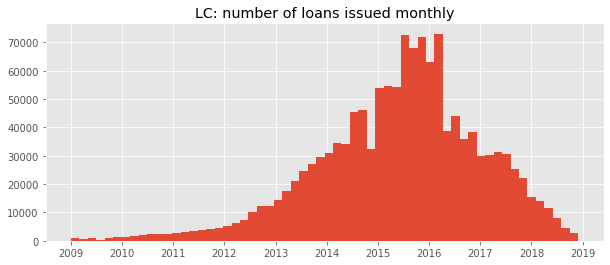

In [23]:
plt.figure(figsize=(10,4))
plt.hist(df.issue_d, bins=60)
plt.title('LC: number of loans issued monthly')
plt.show()

## Missing imputation

The nature of most missing data:
- missing joint application fields for indiv.app.
- missing optional textual descriptions/titles

In [24]:
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing>0].reset_index()
missing

,index,0
0,verification_status_joint,1319502
1,dti_joint,1319300
2,annual_inc_joint,1319297
3,desc,1222129
4,emp_title,85799
5,emp_length,78550
6,title,16660
7,last_pymnt_d,2322
8,revol_util,853
9,dti,374


In [25]:
# desc, emp_title, title
# all these strings are optional. Replace NaN with empty string
# these fields will NOT be treated as categorical (potentially, desc can be input for NLP)
# in contrast, 'purpose' is mandatory, has 14 fixed categories and will be dummified
df.desc.fillna('', inplace=True)
df.emp_title.fillna('', inplace=True)
df.title.fillna('', inplace=True)

In [26]:
# last_pymnt_d is missing only for charged-off and Late 31-120 
# However, 61% of such loans have non-zero total payments (recoveries)
# so there HAS to be a last payment date - important for return regression
# A simplifying assumption is made that in such case, last_pymnt_d ~ last_credit_pull_d

print(df[df.last_pymnt_d.isna()]['loan_status'].value_counts())
df.last_pymnt_d = np.where(df.last_pymnt_d.isna(), df.last_credit_pull_d, df.last_pymnt_d)

# convert date fields to datetime
df.last_pymnt_d = df.last_pymnt_d.apply(make_dateval)
df.earliest_cr_line = df.earliest_cr_line.apply(make_dateval)

Charged Off                                            2312
Does not meet the credit policy. Status:Charged Off      10
Name: loan_status, dtype: int64


In [27]:
# revol_util is NaN for many revol_bal=0 but not only
# assume that revol_util=0, basically unutilized revolving balance
df.revol_util.fillna(0, inplace=True)

In [28]:
# the only missing zip_code comes from AL, impute one of AL zip_codes
df.zip_code.fillna('355xx', inplace=True)

In [29]:
# Joint Applications
# when the loan is joint (legally, a joint obligation), the joint numbers supercede the single numbers :
#    dti_joint  --> if exists, replace dti  
#    annual_inc_joint --> if exists, replace annual_inc
#    verification_status_joint --> if exists AND is 'verified', replace verification_status 

df.dti = np.where(df.application_type=='Joint App', df.dti_joint, df.dti)
df.annual_inc = np.where(df.application_type=='Joint App', df.annual_inc_joint, df.annual_inc)
df.verification_status = np.where(df.verification_status_joint=='Verified', 
                                  df.verification_status_joint, df.verification_status)

# 3 loans have neither dti nor dti_joint, drop them
df[df.dti.isna()]
df = df[~df.dti.isna()]

In [30]:
df.emp_length.value_counts(dropna=False)

10+ years    442174
2 years      121732
< 1 year     107876
3 years      107613
1 year        88407
5 years       84185
4 years       80557
NaN           78550
6 years       62725
8 years       60704
7 years       59623
9 years       50954
Name: emp_length, dtype: int64

In [31]:
# For missing emp.length, assume it's roughly equivalent to years since earliest credit card
def distance_years(distance):
    if distance>=10:   return '10+ years'
    elif distance <1:  return '< 1 year'
    else:              return f'{int(distance)} years'

credit_history = np.round((df.issue_d - df.earliest_cr_line) / np.timedelta64(1,'Y'))
df.emp_length = np.where(df.emp_length.isna(), 
                         np.vectorize(distance_years)(credit_history), 
                         df.emp_length)

In [32]:
# drop the remaining columns with NaN which have been used to populate other fields
df.drop(['verification_status_joint', 'dti_joint', 'annual_inc_joint', 'last_credit_pull_d'], inplace=True, axis=1)

In [33]:
# verify there are no NaNs left
print(df.isna().sum().sum())
df.shape

0


(1345100, 36)

## Finalize dataframe

In [34]:
# create a new field 'has description' (proxy for extra transparency?)
df['_has_desc'] = np.vectorize(len)(df.desc)>0
df._has_desc = df._has_desc.astype(int)
# create a new field for credit history in Years
df['_credit_hist'] = credit_history

In [35]:
ordinal = [
    'application_type', 
    'grade',
    'sub_grade',
    'term',
    'initial_list_status',  # LC claims this is purely random: chi2 test!
    'emp_length',
    'verification_status',
    '_has_desc',
]

In [36]:
df.home_ownership.replace({'ANY':'OTHER', 'NONE':'OTHER'}, inplace=True)

nominal = [
  'purpose',
  'addr_state', # if linear models do not pick up this feature, revisit amd remove dummies (probably too much noise)
  'home_ownership',
  'disbursement_method', #highly imbalanced and probably irrelevant
]

In [37]:
numeric = [
    'loan_amnt', # numeric
    'int_rate',  # numeric
    'installment',  # numeric
    'annual_inc', # numeric
    'fico_range_low', 
    'delinq_2yrs',# numeric
    'dti', # numeric
    'open_acc', # numeric
    'pub_rec', # numeric
    'revol_bal', # numeric
    'revol_util', # numeric
    '_credit_hist', # new numeric
]
print(len(numeric))

12


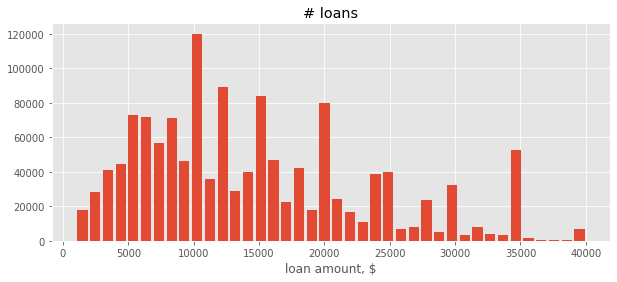

In [38]:
# explore the distribution of loan amount to decide whether to take a log
# conclusion: do not log b/c log_amount is left skewed (overcompensates)
# Spikes at ~round numbers (10K, 20K, 35K) suggest potential binning
plt.figure(figsize=(10,4))
plt.hist(df.loan_amnt, bins=40,rwidth=.8)
plt.xlabel('loan amount, $')
plt.title('# loans')
plt.show()

In [39]:
# check the integrity of numeric columns
for f in numeric:
    print(f'{f} \t{df[f].dtype} \t{df[f].isna().sum()}')

loan_amnt 	float64 	0
int_rate 	float64 	0
installment 	float64 	0
annual_inc 	float64 	0
fico_range_low 	float64 	0
delinq_2yrs 	float64 	0
dti 	float64 	0
open_acc 	float64 	0
pub_rec 	float64 	0
revol_bal 	float64 	0
revol_util 	float64 	0
_credit_hist 	float64 	0


In [40]:
# FREEZE THE DATAFRAME BEYOND THIS POINT
# convert 'id' to numeric and set as index 
df['id'] = df['id'].astype(int)
df.set_index('id', inplace=True)
print(df.shape)
# df.sample(3).T

(1345100, 37)


## Visualize

### Categorical

In [41]:
def plot_categorical(f):
    _,axes = plt.subplots(1, 2, figsize=(14, 4))
    ax0,ax1=axes[0],axes[1]

    distr = df.groupby(f).count()._good
    ax0.bar(distr.index, distr.values)
    rot=0 if len(distr)<8 else 90
    for pos, val in enumerate(distr.values):
        ax0.text(pos, 1.02*val, f'{int(val/1000):,}', rotation=rot, color='k', ha='center')
    ax0.set_title('# of loans per category, thousands')
    plt.setp( ax0.xaxis.get_majorticklabels(), rotation=rot )
    ax0.set_xlabel(f)

    distr = df.groupby(f)._good.mean().sort_values(ascending=False)
    ax1.bar(distr.index, distr.values)
    rot=0 if len(distr)<8 else 90
    for pos, val in enumerate(distr.values):
        ax1.text(pos, 1.02*val, f'{val:.3f}', rotation=rot, color='k', ha='center')
    ax1.set_ylim(0,1)
    ax1.set_title('Share of good loans')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=rot )
    ax1.set_xlabel(f)

    plt.show()


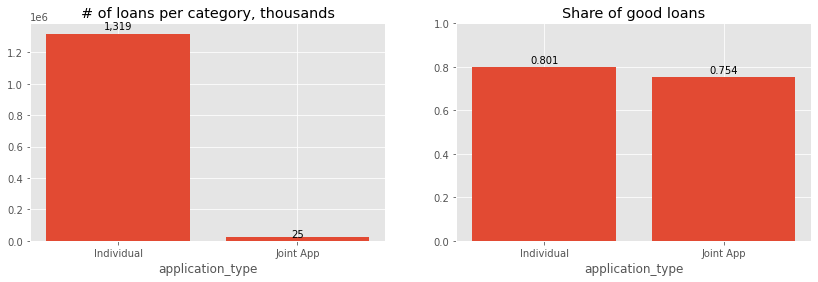

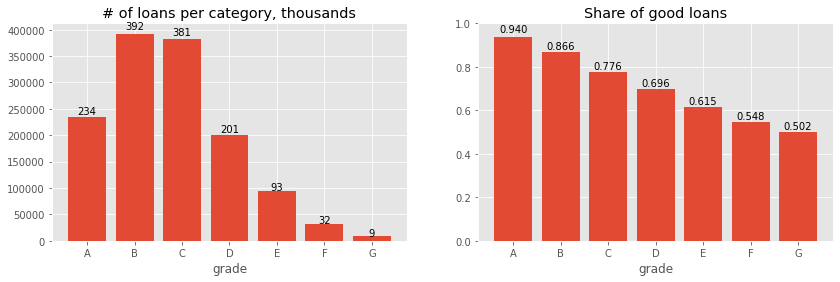

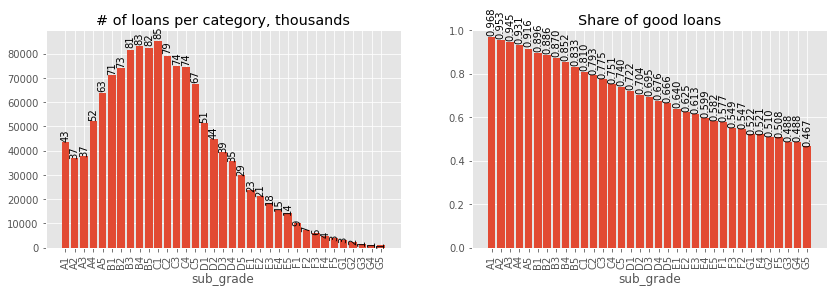

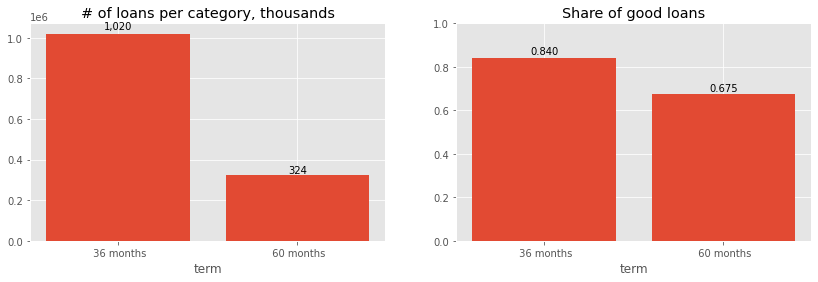

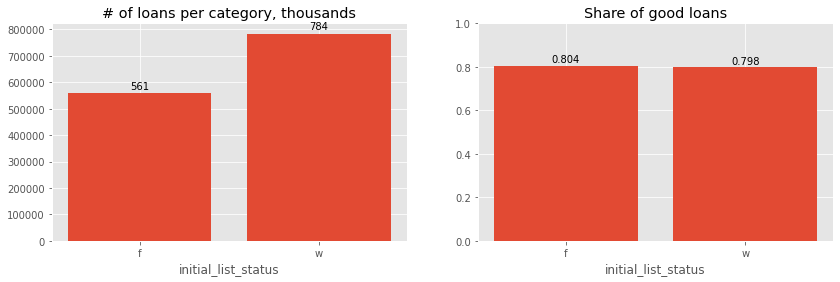

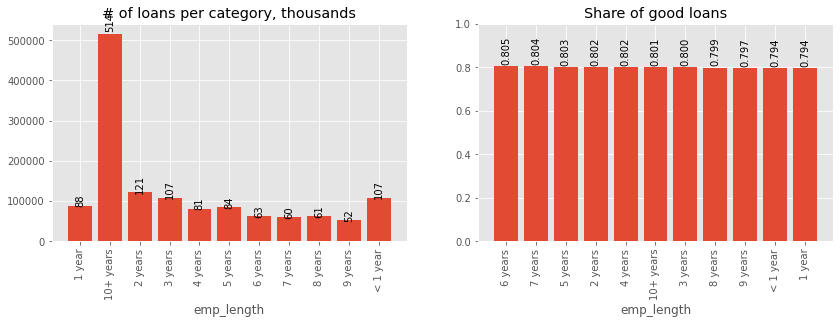

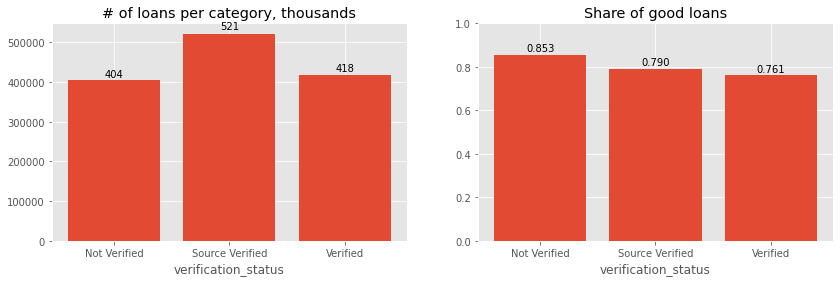

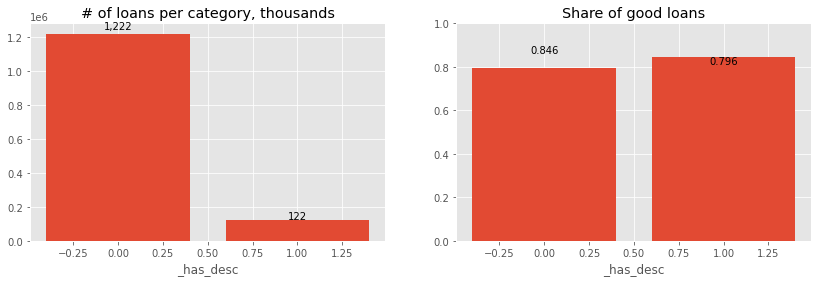

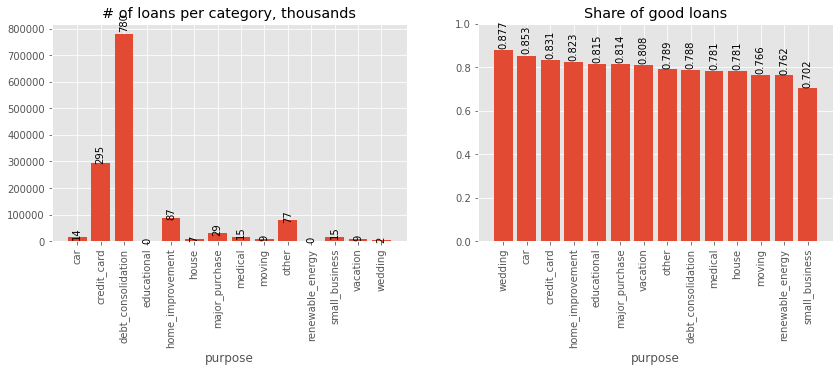

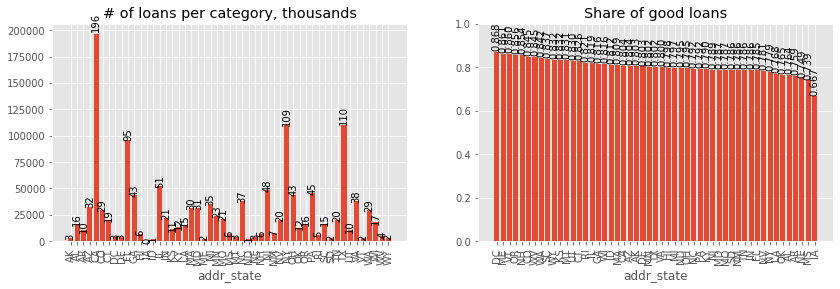

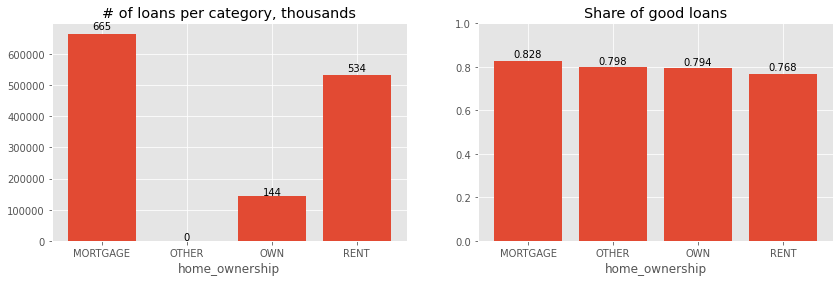

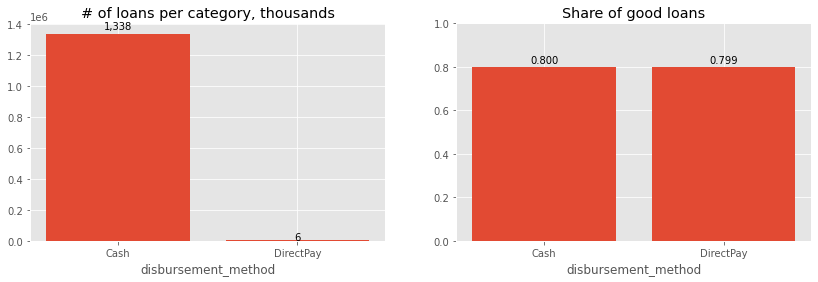

In [42]:
for f in ordinal+nominal:
    plot_categorical(f)

The following fields probably do not influence the default probability. Verify by chi_square tests:
- initial_list_status
- disbursement_method
- emp_length

In [43]:
p_values=[]
for f in ordinal+nominal:
    tab = pd.crosstab(df._good, df[f])
    p_values.append(scipy.stats.chi2_contingency(tab)[1])
sorted(list(zip(ordinal+nominal, p_values)), key=lambda x:x[1])

[('grade', 0.0),
 ('sub_grade', 0.0),
 ('term', 0.0),
 ('verification_status', 0.0),
 ('_has_desc', 0.0),
 ('purpose', 0.0),
 ('addr_state', 0.0),
 ('home_ownership', 0.0),
 ('application_type', 9.776366888251107e-79),
 ('initial_list_status', 6.894830033693952e-16),
 ('emp_length', 6.463066794700236e-11),
 ('disbursement_method', 0.8536480230498579)]

In [44]:
# conclusion: only the disbursement_method is irrelevant, drop the feature
nominal.remove('disbursement_method')

# the state information does not add value, AUC/precision metrics do not change
# remove especially b/c 50 one-hot columns
nominal.remove('addr_state')

### Numeric

In [45]:
def plot_numeric(f):
    _,axes = plt.subplots(1, 2, figsize=(14, 4))
    ax0,ax1=axes[0],axes[1]

    ax0.hist(df[f], bins=40)
    ax0.set_title(f'{f} distribution')
    ax0.set_xlabel(f)

    ax1 = sns.violinplot(f,'_good',data=df, orient='h')
    ax1.set_title(f'{f} vs default')
    ax1.set_xlabel(f)

    plt.show()


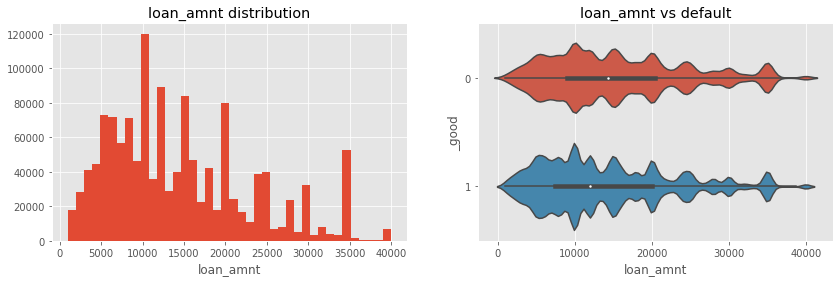

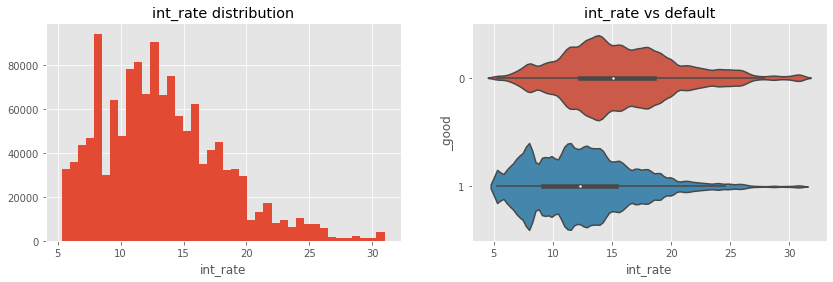

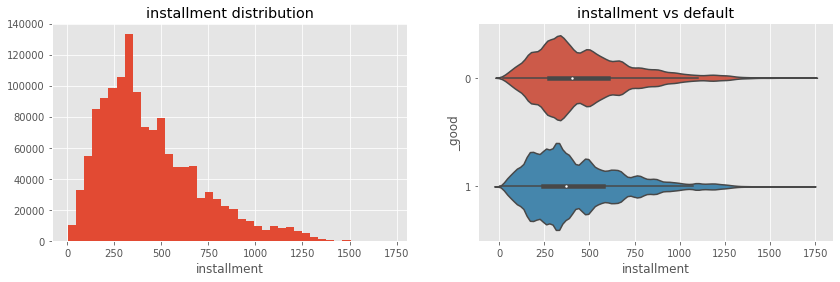

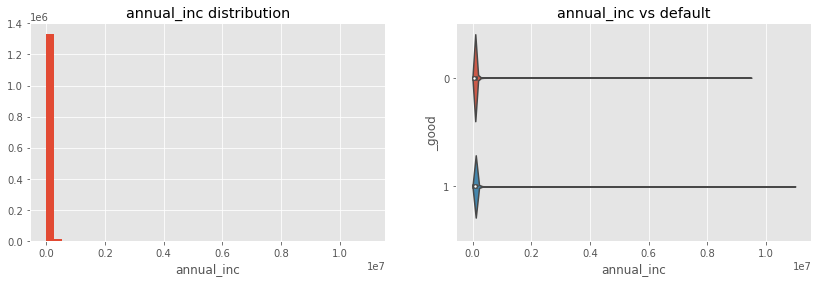

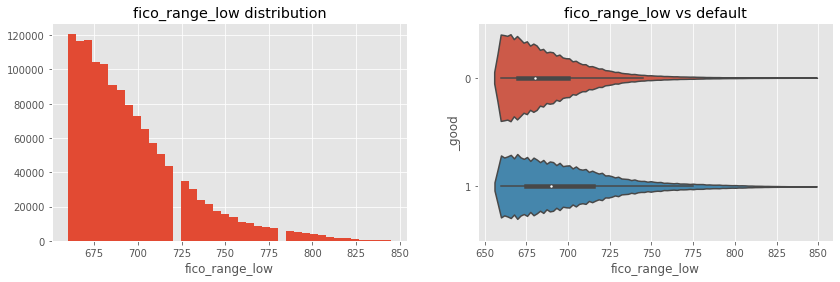

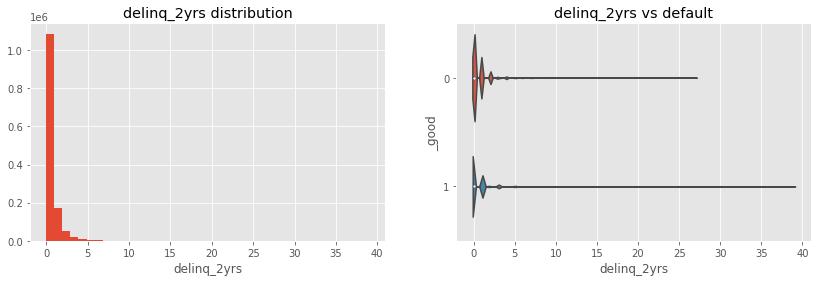

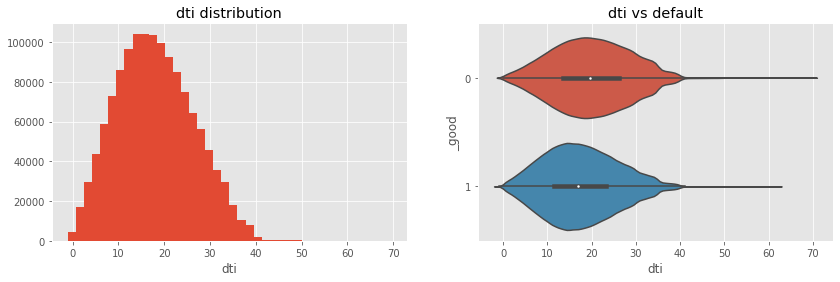

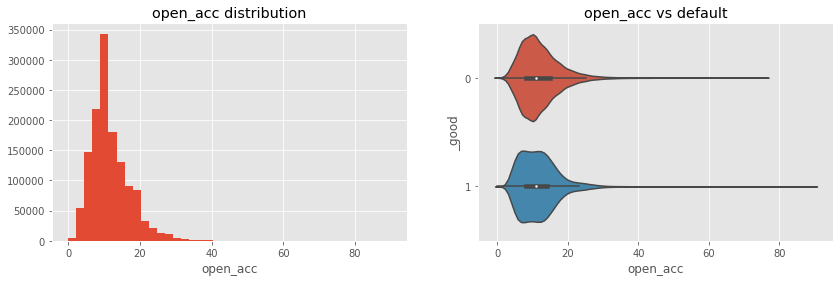

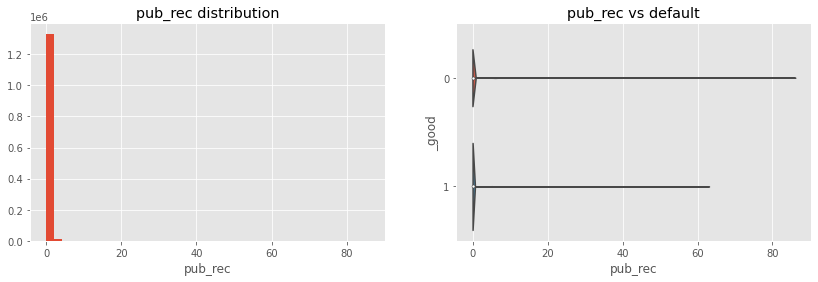

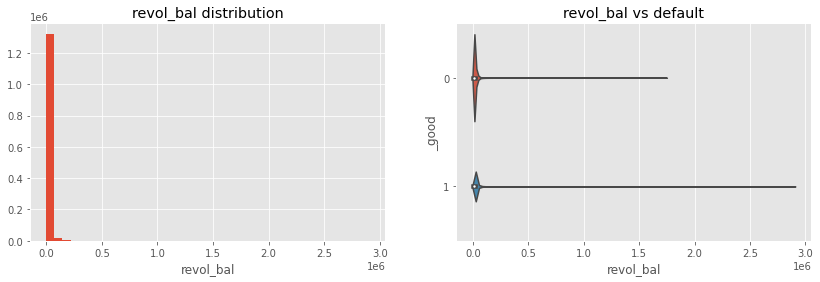

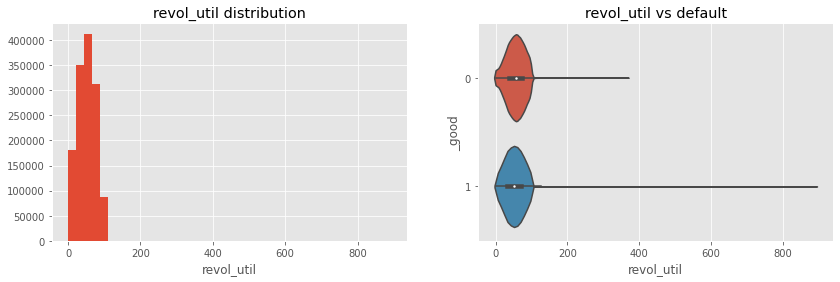

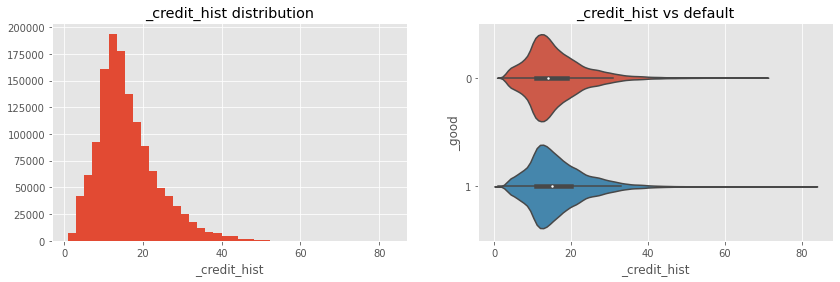

In [46]:
for f in numeric:
    plot_numeric(f)

### Grades stats

In [47]:
grade_dict = {
'% Good': df.groupby('grade')._good.mean(),
'Loan Amount': df.groupby('grade').loan_amnt.mean(),
'FICO low': df.groupby('grade').fico_range_low.mean(),
'Ann.Income': df.groupby('grade').annual_inc.mean(),
'Int.Rate': df.groupby('grade').int_rate.mean(),
'DTI': df.groupby('grade').int_rate.mean(),
'Description': df.groupby('grade')._has_desc.mean(),
'Cred.History': df.groupby('grade').dti.mean(),
}


In [48]:
pd.DataFrame(grade_dict)

,% Good,Loan Amount,FICO low,Ann.Income,Int.Rate,DTI,Description,Cred.History
grade,,,,,,,,
A,0.939561,13902.309548,727.477033,89987.902905,7.111558,7.111558,0.102259,15.478891
B,0.866104,13240.684210,697.103035,77482.967200,10.679999,10.679999,0.105576,17.191322
C,0.775553,14190.182521,687.979389,73974.884125,14.023724,14.023724,0.077060,18.636687
D,0.696121,15265.555412,683.289889,71501.207396,17.722076,17.722076,0.081953,19.842614
E,0.615242,17602.201328,682.052352,73187.284693,21.133141,21.133141,0.079546,20.490151
F,0.548206,19071.472016,679.897023,74337.413608,24.920397,24.920397,0.102946,20.662194
G,0.501684,20525.738729,678.548615,78299.778136,27.669288,27.669288,0.094948,20.770961


In [49]:
# visualize

## X,Y: train/test split

In [50]:
print(df.shape)
print(df.columns)

(1345100, 37)
Index(['issue_d', 'desc', 'title', 'application_type', 'purpose', 'grade',
       'sub_grade', 'term', 'loan_amnt', 'int_rate', 'installment',
       'initial_list_status', 'disbursement_method', 'addr_state', 'zip_code',
       'home_ownership', 'emp_length', 'emp_title', 'annual_inc',
       'verification_status', 'fico_range_high', 'fico_range_low',
       'delinq_2yrs', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'loan_status', 'funded_amnt', 'total_pymnt',
       'last_pymnt_d', 'recoveries', '_good', '_has_desc', '_credit_hist'],
      dtype='object')


In [51]:
Y = df['_good']
X = df[nominal + ordinal + numeric]

X.sample(5)

,purpose,home_ownership,application_type,grade,sub_grade,term,initial_list_status,emp_length,verification_status,_has_desc,loan_amnt,int_rate,installment,annual_inc,fico_range_low,delinq_2yrs,dti,open_acc,pub_rec,revol_bal,revol_util,_credit_hist
id,,,,,,,,,,,,,,,,,,,,,,
39280495,debt_consolidation,RENT,Individual,B,B3,36 months,f,2 years,Not Verified,0,7200.0,10.49,233.99,60000.0,670.0,0.0,4.74,9.0,0.0,5094.0,26.7,10.0
1401914,credit_card,MORTGAGE,Individual,C,C1,36 months,f,10+ years,Verified,1,25225.0,14.33,866.18,70000.0,710.0,0.0,22.90,10.0,0.0,23946.0,81.7,17.0
45764162,debt_consolidation,MORTGAGE,Individual,B,B4,60 months,w,10+ years,Source Verified,0,25000.0,10.99,543.44,96712.0,705.0,0.0,11.66,9.0,0.0,12472.0,75.6,19.0
50103851,home_improvement,MORTGAGE,Individual,D,D1,60 months,w,10+ years,Verified,0,12000.0,15.61,289.34,115000.0,665.0,0.0,9.66,4.0,1.0,0.0,0.0,11.0
46642488,credit_card,RENT,Individual,A,A2,36 months,w,5 years,Source Verified,0,18000.0,6.39,550.79,101000.0,670.0,0.0,9.15,5.0,2.0,24440.0,62.7,10.0


1. Convert Ordinal to numeric

In [52]:
sub_grades = sorted(df.sub_grade.unique())
sub_grades_dict = {x:sub_grades.index(x)+1 for x in sub_grades}  # map 'A1' to 1 rather than 0
sub_grades_dict_reverse = {v:k for k,v in sub_grades_dict.items()} # for visual purposes, need later

emp_length_dict =  {'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, 
                    '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10,}
ordinal_dict = {
    'application_type': {'Individual':0, 'Joint App':1},
    'grade':   {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7},
    'sub_grade': sub_grades_dict,
    'term': {' 36 months':0, ' 60 months':1},
    'initial_list_status': {'w':0, 'f':1}, 
    'emp_length': emp_length_dict,
    'verification_status': {'Not Verified':0, 'Source Verified':1, 'Verified':2},  #'source verified' is a softer check
    '_has_desc': {False:0, True:1}
}

for f in ordinal:
    X[f].replace(ordinal_dict[f], inplace=True)

X.sample(5)

,purpose,home_ownership,application_type,grade,sub_grade,term,initial_list_status,emp_length,verification_status,_has_desc,loan_amnt,int_rate,installment,annual_inc,fico_range_low,delinq_2yrs,dti,open_acc,pub_rec,revol_bal,revol_util,_credit_hist
id,,,,,,,,,,,,,,,,,,,,,,
17654290,debt_consolidation,MORTGAGE,0,5,22,1,1,10,1,0,26400.0,19.52,692.41,70000.0,695.0,0.0,27.64,10.0,0.0,4938.0,70.5,19.0
72523064,debt_consolidation,OWN,0,4,17,0,1,10,2,0,15200.0,17.27,543.97,50678.7,675.0,1.0,25.29,6.0,0.0,2296.0,99.8,12.0
67475117,debt_consolidation,MORTGAGE,0,2,8,0,0,10,0,0,20000.0,9.76,643.10,108021.0,705.0,1.0,16.63,17.0,0.0,7695.0,31.3,25.0
134953411,home_improvement,MORTGAGE,0,2,6,0,1,10,1,0,10000.0,9.58,320.71,300000.0,740.0,0.0,13.81,10.0,0.0,121779.0,38.2,17.0
6297464,debt_consolidation,RENT,0,3,15,0,0,4,2,1,11200.0,16.78,398.09,85000.0,675.0,1.0,14.13,21.0,0.0,13468.0,23.9,10.0


2. Dummify the Nominal

In [53]:
# verify the object types:
for f in nominal:
    assert X[f].dtype=='object'
for f in ordinal+numeric:
    assert X[f].dtype!='object'

# dummify
X = pd.get_dummies(X, columns=nominal,  drop_first=True)

print(X.shape)
assert X.shape[0]==Y.shape[0]
X.sample(5)

(1345100, 36)


,application_type,grade,sub_grade,term,initial_list_status,emp_length,verification_status,_has_desc,loan_amnt,int_rate,installment,annual_inc,fico_range_low,delinq_2yrs,dti,open_acc,pub_rec,revol_bal,revol_util,_credit_hist,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69444446,0,2,10,0,0,10,1,0,10000.0,11.48,329.67,54000.0,665.0,0.0,18.09,13.0,0.0,15082.0,48.5,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15710283,0,3,14,0,0,8,0,0,1000.0,15.31,34.82,42000.0,665.0,1.0,19.69,4.0,1.0,1663.0,55.4,8.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
61479085,0,1,3,0,0,10,0,0,10000.0,6.89,308.27,85000.0,720.0,1.0,18.01,9.0,0.0,5879.0,37.0,23.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
92932422,0,1,5,1,0,7,2,0,33150.0,7.99,672.01,520000.0,740.0,0.0,11.96,8.0,0.0,29872.0,69.5,23.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23103254,0,3,11,0,1,0,1,0,5600.0,12.99,188.66,34000.0,670.0,0.0,6.11,6.0,1.0,4839.0,49.4,7.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Select between testing on the most recent loans vs random sampling across dates

In [54]:
test_mode = 'random'

if test_mode=='recent':
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

if test_mode=='random':
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2020)    

In [55]:
# (TBD: for presentation purposes, visualize the recent train/test split on a timeline)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1076080, 36)
(269020, 36)
(1076080,)
(269020,)


Verify the X_train, X_test dates (if test_mode='recent')

In [56]:
# verify the dates
df_train = df[df.index.isin(X_train.index)]
df_test = df[df.index.isin(X_test.index)]

print(min(df_train.issue_d))
print(max(df_train.issue_d))
print(min(df_test.issue_d))
print(max(df_test.issue_d))

2009-01-01 00:00:00
2018-12-01 00:00:00
2009-01-01 00:00:00
2018-12-01 00:00:00


In [57]:
print(max(df_train.last_pymnt_d))
print(max(df_test.last_pymnt_d))

2019-03-01 00:00:00
2019-03-01 00:00:00


For random sampling, the % of default is identical to total population:
- 0.80042, 0.19958

The most recent loans, however, skew this proportion towards defaulted loans b/c they are more likely to 'develop' the target variable before maturity:
- 0.782146, 0.217854

We have to be careful in interpreting the ROC curve for the most recent test set. Possible solution: slight upsampling of the recent good loans.

## Save csv

In [58]:
def save_features(X_train, X_test, Y_train, Y_test, test_mode):
    timestamp = int(time.time())
    X_train.to_csv(path+f'features/X_train_{test_mode}_{timestamp}.csv')
    X_test.to_csv(path+f'features/X_test_{test_mode}_{timestamp}.csv')
    Y_train.to_csv(path+f'features/Y_train_{test_mode}_{timestamp}.csv')
    Y_test.to_csv(path+f'features/Y_test_{test_mode}_{timestamp}.csv')    

In [59]:
# save_features(X_train, X_test, Y_train, Y_test, test_mode)

# 2. Classification

Input data: X,Y train/val/test dataframes

HP / input parameters:
- all subgrades / indicate subgrade
- all features / indicate feature
- models: nn / logistic / XGBoost

Cycle:
- produce new X,Y train/val/test dataframes
- normalize, truncate
- call Function
- add metrics to report_df

Function:
1.   train model
2.   predict Y_train_hat, Y_test_hat 
3.   produce metrics
4.   optional: plot roc, precision graph
5.   return metrics 




### Helper Functions

In [60]:
def normalize_arrays(fit_arr, *arrs):
    scaler = StandardScaler()
    fit_arr = scaler.fit_transform(fit_arr)
    out=[]
    for arr in arrs:
        out.append(scaler.transform(arr))
    return [fit_arr]+out

def truncate_outliers(*arrs, sd_max=5):
    out = []
    for arr in arrs:
        out.append(np.clip(arr, -sd_max, sd_max))
    return out


In [61]:
def save_predictions(Y_test, Y_test_hat, test_mode):
    
    timestamp = int(time.time())
    filename = f'predictions_{test_mode}_{timestamp}.csv'
    
    Y_test_hat = pd.Series(np.squeeze(Y_test_hat), name='p', index=Y_test.index)
    predictions=pd.concat([Y_test, Y_test_hat], axis=1)
    predictions.to_csv(path+'features/'+filename)
    
    print(f'saved: {filename}')

In [62]:
def save_report(df_report, test_mode):
    
    timestamp = int(time.time())
    filename = f'report_{test_mode}_{timestamp}.csv'
    
    df_report.to_csv(path+'reports/'+filename)
    
    print(f'saved: {filename}')

In [63]:
def plot_roc(Y_train_hat, Y_test_hat, Y_train, Y_test, model_name):

    AUC_train = roc_auc_score(Y_train, Y_train_hat)
    AUC_test = roc_auc_score(Y_test, Y_test_hat)

    fp_train, tp_train, _ = roc_curve(Y_train, Y_train_hat)
    fp_test, tp_test, thresholds = roc_curve(Y_test, Y_test_hat)

    precision = 1/(1+ (1/np.mean(Y_test)-1)*(fp_test/tp_test))
    thresholds[0]=1  #sklearn may produce arbitrary first threshold > 1

    ref_thresholds = np.linspace(min(thresholds), max(thresholds),1000)
    selected = [np.nanmean(Y_test_hat>p) for p in ref_thresholds]

    _,axes = plt.subplots(1, 2, figsize=(14, 6))
    ax0,ax1=axes[0],axes[1]

    ax0.plot(fp_train, tp_train, label=f'Train. AUC={AUC_train:.4f}')
    ax0.plot(fp_test, tp_test, label=f'Test. AUC={AUC_test:.4f}')
    ax0.plot((0,1),(0,1), color='grey')
    ax0.plot((np.mean(Y_train)), (np.mean(Y_train)), color='grey', marker='o', label='random')
    ax0.set_xlabel('false positive rate')
    ax0.set_ylabel('recall')
    ax0.set_title(f'ROC: {model_name}')
    ax0.legend(loc='lower right')
    ax0.grid(True)

    ax1.plot(thresholds, precision, label=f'precision')
    ax1.plot(ref_thresholds, selected, label=f'selected %')
    ax1.set_xlabel('cutoff thresholds')
    ax1.set_title(f'Precision and selected %')
    ax1.legend(loc='lower right')
    ax1.invert_xaxis()
    ax1.grid(True)

    plt.show()

In [64]:
def plot_report_metrics(df_report, test_mode):
    fig,axes = plt.subplots(1, 2, figsize=(14, 5))
    ax0,ax1=axes[0],axes[1]
    model_name = df_report.model[0]

    for col in ['prec_5','prec_10','prec_20','support']:
        ax0.plot(df_report.run, df_report[col]/df_report['support'], label=col)
    ax0.set_title(f'{test_mode} OOS   {model_name}   Lift')
    ax0.set_ylabel('lift')
    ax0.legend()

    for col in ['support','AUC_test']:
        ax1.plot(df_report.run, df_report[col], label=col)
    ax1.set_title(f'{test_mode} OOS   {model_name}   AUC')
    ax1.legend()

    plt.show()


### Training & Prediction

In [65]:
def model_train(X_train, X_val, Y_train, Y_val, model_name, **kwargs):
    
    verbose = 0 if 'verbose' not in kwargs.keys() else kwargs['verbose']

    # 1. NEURAL NETWORK ========================
    if 'neural' in model_name:
        neg, pos = np.bincount(Y_train)
        EPOCHS = 40
        BATCH_SIZE = 1024

        # small fully connected, anything more powerful overfits
        model = keras.Sequential([
            keras.layers.Dense(256, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.001),
                            input_shape=(X_train.shape[-1],)),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation='sigmoid',
                            bias_initializer=tf.keras.initializers.Constant(np.log(pos/neg))),
        ])
        
        model.compile(
            optimizer=keras.optimizers.Adam(lr=1e-4),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=[keras.metrics.Precision(name='precision'), 
                     keras.metrics.Recall(name='recall'), 
                     keras.metrics.AUC(name='auc'),])
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
            patience=5, mode='max', restore_best_weights=True)
        
        history = model.fit(
            X_train,
            Y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=verbose,
            callbacks = [early_stopping],
            validation_data=(X_val, Y_val))
        
    # 2. LOGISTIC REGRESSION ========================
    if 'logistic' in model_name:
        model = LogisticRegression(penalty='l1', 
                                   C=100, 
                                   verbose=verbose,
                                   solver='liblinear') # best HP from BD18
        model.fit(X_train, Y_train)

    # 3. XGBoost ========================
    if 'xgboost' in model_name:
        model= XGBClassifier(base_score=0.8, 
                            colsample_bylevel=0.5,   #<<<<<
                            colsample_bytree=0.5,  #<<<<<
                            gamma=0, 
                            learning_rate=1,  #<<<<<
                            max_depth=3, 
                            min_child_weight=0, 
                            n_estimators=2000,   #<<<<< 
                            nthread=-1, 
                            objective='binary:logistic',
                            reg_alpha=0.5, 
                            reg_lambda=1, 
                            seed=0, silent=False,
                            subsample=0.5)
        model.fit(X_train, Y_train)
    return model


In [66]:
def predict_probs(X_train, X_test, Y_train, Y_test,
                   model_name,
                   select_top=[0.05, 0.1, 0.2],
                   show_plot=True,
                   **kwargs
                   ):
    """Implement the cycle of training, predicting, and producing basic metrics
    Args:   X,Y  split into  train/val/test 
            model name
            hyperparameters
    Returns: arrays with Y_test {1:good,0:default) and Y_test_hat (probabilities)
             AUC_train, AUC_test
             precision and support metric for selected % of loans (HP select_top)
    """
    # 1. Split 5% validation, Normalize
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.05)
    X_train, X_val, X_test = normalize_arrays(X_train, X_val, X_test)
    X_train, X_val, X_test = truncate_outliers(X_train, X_val, X_test)

    # 2. train model
    verbose = 0 if 'verbose' not in kwargs.keys() else kwargs['verbose']
    tic = time.time()
    model = model_train(X_train, X_val, Y_train, Y_val, model_name, verbose=verbose)
    print(f'model trained in {time.time()-tic:.1f}sec')        

    # 3. predict Y_train_hat, Y_test_hat
    if 'neural' in model_name:
        Y_train_hat = model.predict(X_train)
        Y_test_hat = model.predict(X_test)
    else:
        Y_train_hat = model.predict_proba(X_train)[:,1]
        Y_test_hat = model.predict_proba(X_test)[:,1]

    # 4. Produce metrics
    AUC_train = roc_auc_score(Y_train, Y_train_hat)
    AUC_test = roc_auc_score(Y_test, Y_test_hat)
    fp_test, tp_test, thresholds = roc_curve(Y_test, Y_test_hat)

    support = np.nanmean(Y_test)
    indices = np.searchsorted(thresholds[::-1], np.quantile(Y_test_hat, 1-np.array(select_top)))
    precision = 1/(1 + (fp_test[-indices]/tp_test[-indices])*(1/support-1))
    precision = {k:v for k,v in zip(select_top, precision)}
    precision.update({1:support})

    # 5. Optional: plot roc, precision graph
    if show_plot:
        plot_roc(Y_train_hat, Y_test_hat, Y_train, Y_test, model_name)
    
    print(f'{AUC_train:.5f} {AUC_test:.5f} \n{precision}')
    
    # include Y_test in the output for verification purposes (Y_test<-->Y_test_hat)
    return Y_test, Y_test_hat, AUC_train, AUC_test, precision

### All Loans classification

#### Neural Network

model trained in 166.2sec


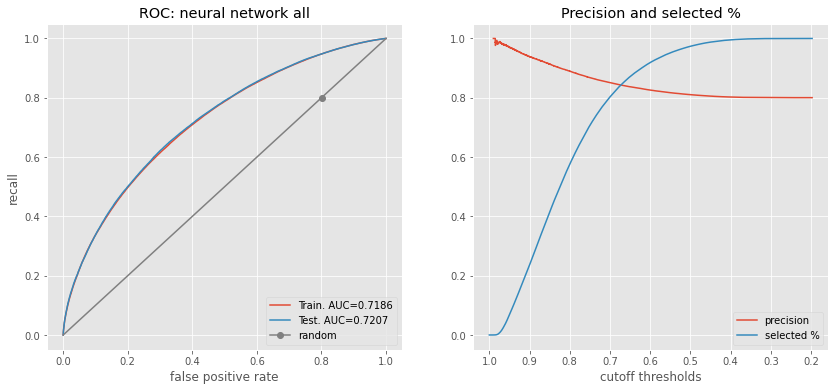

0.71858 0.72068 
{0.05: 0.9740636147443521, 0.1: 0.964195513296687, 0.2: 0.9444888401568511, 1: 0.800408891532228}


In [67]:
Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
    predict_probs(X_train, X_test, Y_train, Y_test, 
                'neural network all', 
                show_plot=True, 
                verbose=0)

# save_predictions(Y_test, Y_test_hat, test_mode)

#### Logistic Regression

model trained in 58.5sec


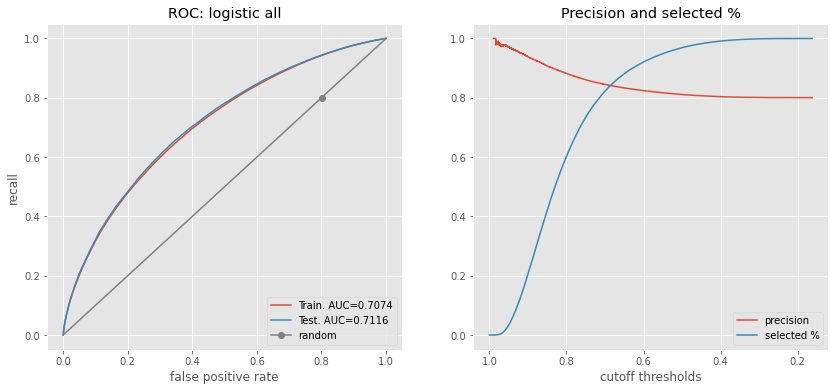

0.70742 0.71158 
{0.05: 0.9658612281090667, 0.1: 0.9566880873667398, 0.2: 0.938797509525137, 1: 0.800408891532228}


In [68]:
Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
    predict_probs(X_train, X_test, Y_train, Y_test, 
                'logistic all', 
                show_plot=True, 
                verbose=0)

# save_predictions(Y_test, Y_test_hat, test_mode)

#### XGBoost Classifier

model trained in 540.4sec


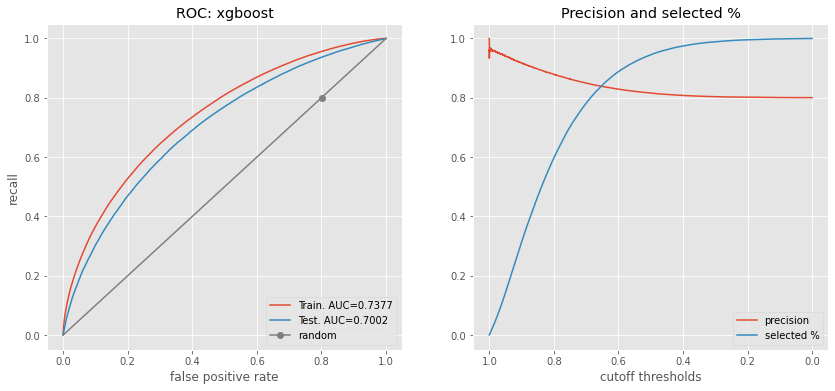

0.73772 0.70021 
{0.05: 0.9556792873051224, 0.1: 0.9474446590402614, 0.2: 0.9324238932461064, 1: 0.800408891532228}


In [69]:
Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
    predict_probs(X_train, X_test, Y_train, Y_test, 
                'xgboost', 
                show_plot=True, 
                verbose=0)

# save_predictions(Y_test, Y_test_hat, test_mode)   

### NN Sequential Retraining

In [70]:
# a general report dataframe structure:
df_template = pd.DataFrame(columns=['model',
                                  'test_year',
                                  'sec',
                                  'n_loans',
                                  'AUC_test',
                                  'prec_5',
                                  'prec_10',
                                  'prec_20',
                                  'support',
                                  'lift_5',
                                  'lift_10',
                          
                                  'lift_20',
                                  ])
df_template

,model,test_year,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20


In [128]:
df['issue_year'] = df.issue_d.apply(lambda x: x.year)

predictions = pd.DataFrame(columns=['_good','p'])
model_name = 'neural_256'
df_report = df_template.copy()


timestamp = int(time.time())
X.to_csv(path+f'sequential/X_full_{timestamp}.csv')
Y.to_csv(path+f'sequential/Y_full_{timestamp}.csv')

for test_year in range(2010, 2019):

    tic = time.time()

    train_indices = df[df.issue_year<test_year].index
    test_indices = df[df.issue_year==test_year].index

    X_train_seq = X.loc[train_indices]
    Y_train_seq = Y.loc[train_indices]

    X_test_seq = X.loc[test_indices]
    Y_test_seq = Y.loc[test_indices]

    Y_test_seq, Y_test_hat_seq, AUC_train, AUC_test, precision =\
        predict_probs(X_train_seq, X_test_seq, Y_train_seq, Y_test_seq,
                    model_name, 
                    show_plot=False, 
                    verbose=0)

    Y_test_hat_seq = pd.Series(np.squeeze(Y_test_hat_seq), name='p', index=Y_test_seq.index)
    predictions_seq = pd.concat([Y_test_seq, Y_test_hat_seq], axis=1)
    predictions = pd.concat([predictions, predictions_seq], axis=0)

    df_report.loc[df_report.shape[0]] = ([model_name] +
                                         [test_year] +
                                         [f'{time.time()-tic:.1f}'] + 
                                         [f'{len(Y_test_hat_seq):,}'] +
                                         [np.round(AUC_test, 4)] +
                                         [np.round(x,4) for x in precision.values()] + 
                            [np.round(x/precision[1],4) for x in list(precision.values())[:-1]] 
                                        )
    print(f'{test_year} completed: \t{time.time()-tic:.1f} sec')
    print('='*60)

predictions.index.rename('id', inplace=True)
predictions.to_csv(path+f'sequential/Y_predictions_{timestamp}.csv')
predictions.shape
predictions.head()

model trained in 2.0sec
0.42955 0.42129 
{0.05: 0.8040435458786935, 0.1: 0.8108108108108107, 0.2: 0.815506958250497, 1: 0.8598548297040759}
2010 completed: 	2.5 sec
model trained in 6.3sec
0.69883 0.69303 
{0.05: 0.9738503155996393, 0.1: 0.9678012879484821, 0.2: 0.9501378676470589, 1: 0.8482114083145343}
2011 completed: 	7.3 sec
model trained in 7.8sec
0.70513 0.67376 
{0.05: 0.9640987284966342, 0.1: 0.9531747518261847, 0.2: 0.9374414684397827, 1: 0.8380272453014035}
2012 completed: 	10.0 sec
model trained in 16.6sec
0.69673 0.68465 
{0.05: 0.9679905157083579, 0.1: 0.9603409933283914, 0.2: 0.9468980605925761, 1: 0.8440402361947716}
2013 completed: 	21.8 sec
model trained in 26.8sec
0.69483 0.70758 
{0.05: 0.9702428968360671, 0.1: 0.959806425594838, 0.2: 0.9436663903018352, 1: 0.8155022568051528}
2014 completed: 	38.4 sec
model trained in 57.2sec
0.70655 0.73211 
{0.05: 0.9758304940374787, 0.1: 0.9646679801906384, 0.2: 0.9482014963124684, 1: 0.7981493562688892}
2015 completed: 	76.1 sec

,_good,p
id,,
478172,1,0.896331
478174,1,0.904626
478200,0,0.940307
478163,1,0.872470
477510,1,0.868642


In [72]:
timestamp = int(time.time())
filename = f'sequential_predictions_{timestamp}.csv'

predictions.index.rename('id', inplace=True)
predictions.to_csv(path+'features/'+filename)
predictions.shape
predictions.head()

,_good,p
id,,
478172,1,0.828222
478174,1,0.885869
478200,0,0.752637
478163,1,0.900471
477510,1,0.921105


In [73]:
predictions.shape

(1339819, 2)

In [74]:
df_report

,model,test_year,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20
0,neural_256,2010,4.2,"12,537",0.6562,0.9591,0.9444,0.9392,0.8599,1.1154,1.0983,1.0923
1,neural_256,2011,4.9,"21,721",0.6903,0.9612,0.9559,0.9500,0.8482,1.1332,1.1269,1.1200
2,neural_256,2012,11.2,"53,367",0.6755,0.9668,0.9536,0.9383,0.8380,1.1536,1.1379,1.1197
3,neural_256,2013,22.0,"134,804",0.6834,0.9676,0.9591,0.9482,0.8440,1.1463,1.1364,1.1234
4,neural_256,2014,46.4,"223,103",0.7073,0.9715,0.9611,0.9438,0.8155,1.1913,1.1785,1.1573
5,neural_256,2015,89.1,"375,545",0.7323,0.9757,0.9647,0.9480,0.7981,1.2224,1.2087,1.1877
6,neural_256,2016,125.6,"293,103",0.7120,0.9678,0.9549,0.9314,0.7671,1.2615,1.2447,1.2142
7,neural_256,2017,170.2,"169,321",0.7072,0.9716,0.9569,0.9315,0.7687,1.2640,1.2449,1.2118
8,neural_256,2018,220.2,"56,318",0.7116,0.9796,0.9737,0.9607,0.8424,1.1628,1.1558,1.1404


### NN Feature Importance

model trained in 6.4sec


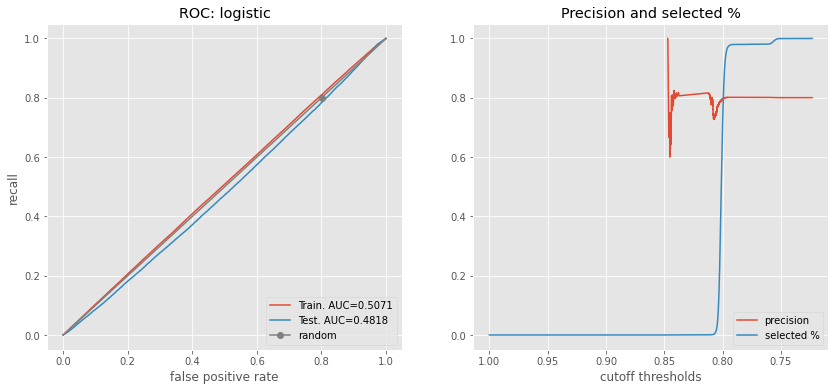

0.50709 0.48181 
{0.05: 0.7721528397264347, 0.1: 0.7759114051060982, 0.2: 0.7845527699827167, 1: 0.800408891532228}
application_type 	11 sec
model trained in 4.7sec


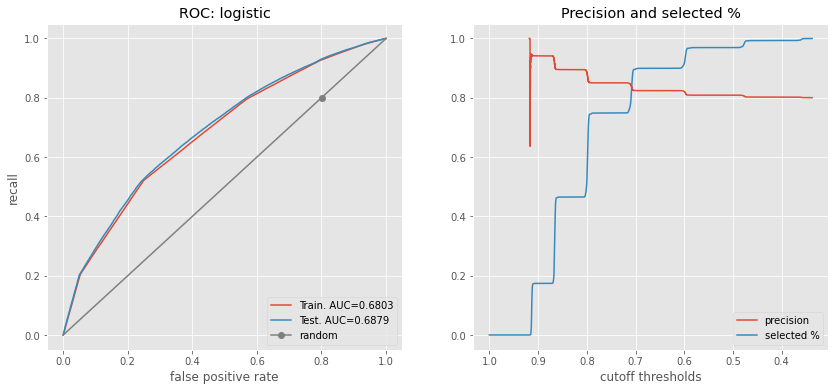

0.68029 0.68792 
{0.05: 0.9442174849587759, 0.1: 0.9430577223088923, 0.2: 0.9330211121022896, 1: 0.800408891532228}
grade 	21 sec
model trained in 9.1sec


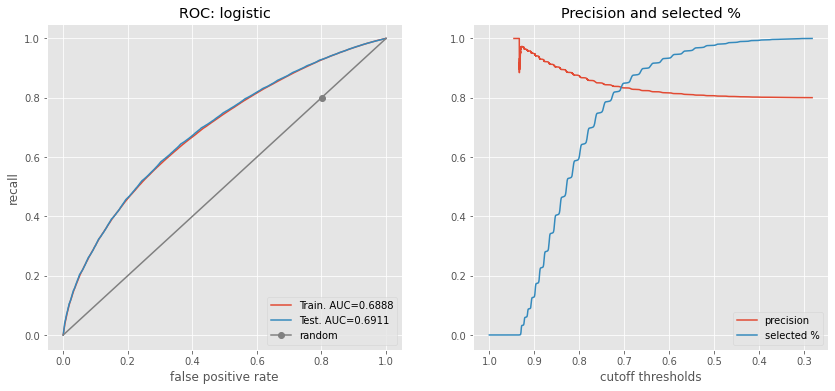

0.68879 0.69114 
{0.05: 0.9659217462320884, 0.1: 0.9536517375952426, 0.2: 0.933843752322902, 1: 0.800408891532228}
sub_grade 	35 sec
model trained in 5.5sec


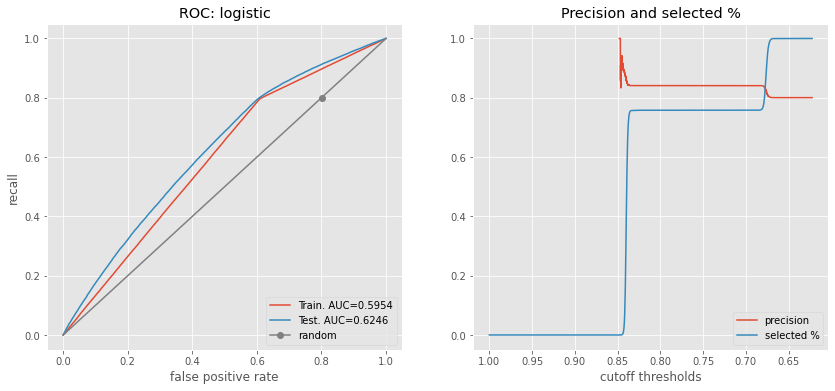

0.59542 0.62455 
{0.05: 0.8863872789418933, 0.1: 0.8799390402557336, 0.2: 0.8723522853957637, 1: 0.800408891532228}
term 	46 sec
model trained in 13.7sec


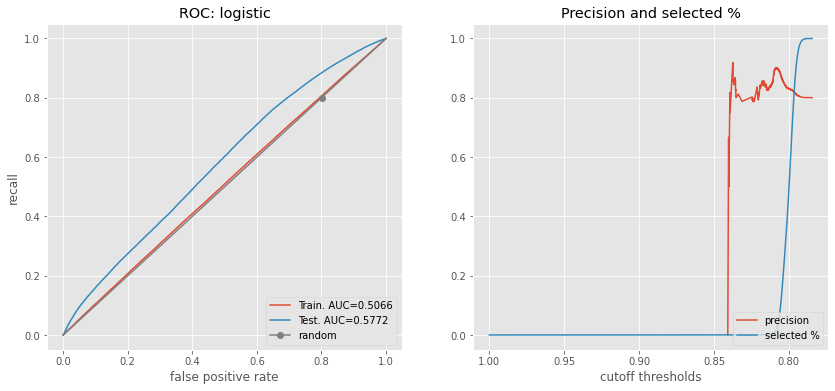

0.50655 0.57723 
{0.05: 0.8925306577480491, 0.1: 0.8784522172248449, 0.2: 0.854586005018121, 1: 0.800408891532228}
initial_list_status 	64 sec
model trained in 54.7sec


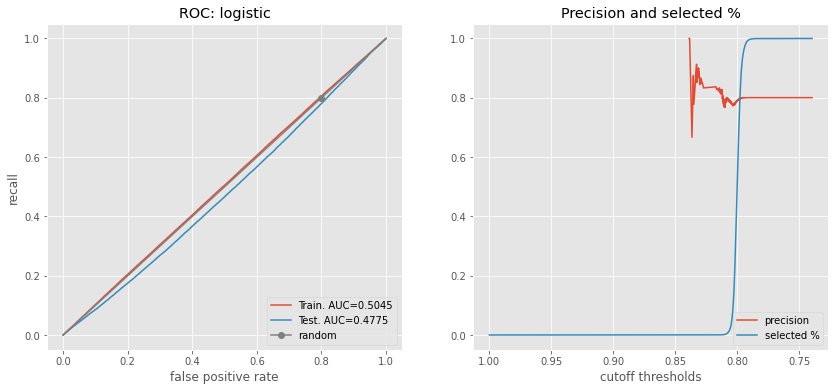

0.50449 0.47752 
{0.05: 0.7793134195274186, 0.1: 0.7740484686292001, 0.2: 0.7789280005947292, 1: 0.800408891532228}
emp_length 	123 sec
model trained in 35.5sec


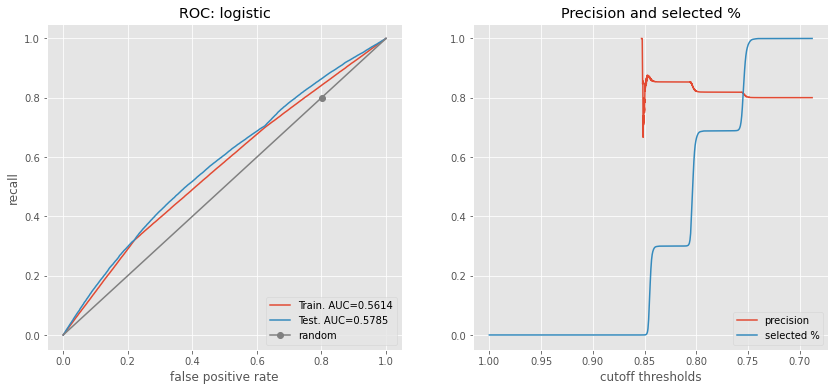

0.56139 0.57851 
{0.05: 0.8724921979491752, 0.1: 0.8706560118936999, 0.2: 0.8631455704436062, 1: 0.800408891532228}
verification_status 	164 sec
model trained in 11.4sec


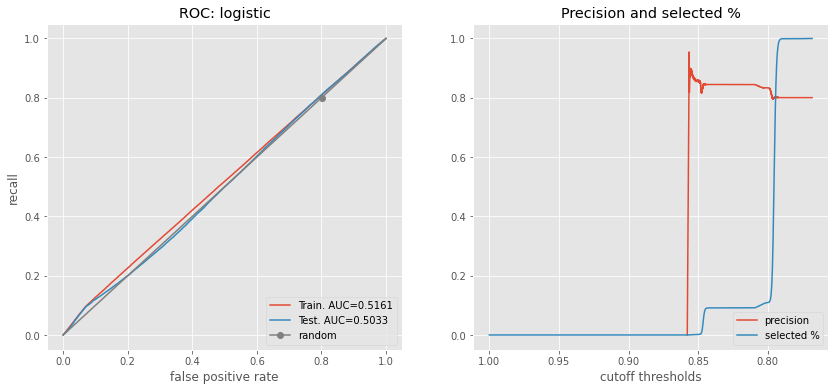

0.51608 0.50327 
{0.05: 0.8432552954292085, 0.1: 0.836733935407143, 0.2: 0.8004087699739872, 1: 0.800408891532228}
_has_desc 	180 sec
model trained in 5.7sec


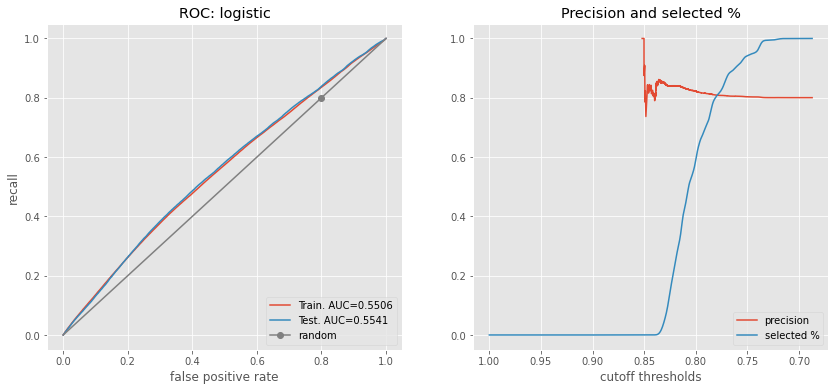

0.55055 0.55414 
{0.05: 0.8495726495726496, 0.1: 0.8404192061840344, 0.2: 0.8405463160828764, 1: 0.800408891532228}
loan_amnt 	191 sec
model trained in 14.0sec


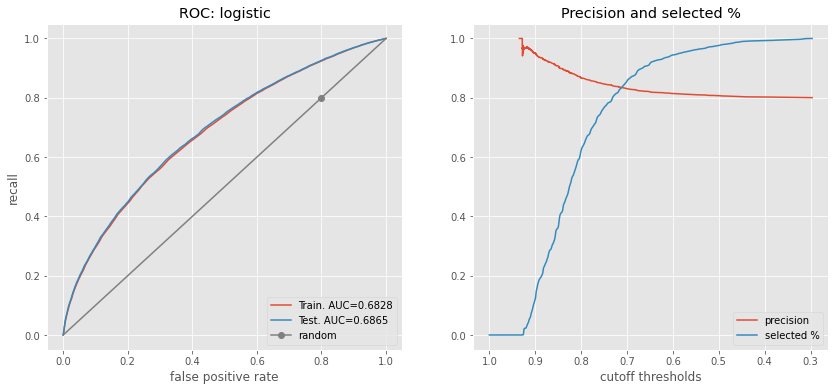

0.68277 0.68652 
{0.05: 0.9659732540861813, 0.1: 0.9535860274990708, 0.2: 0.9344914073385973, 1: 0.800408891532228}
int_rate 	210 sec
model trained in 4.4sec


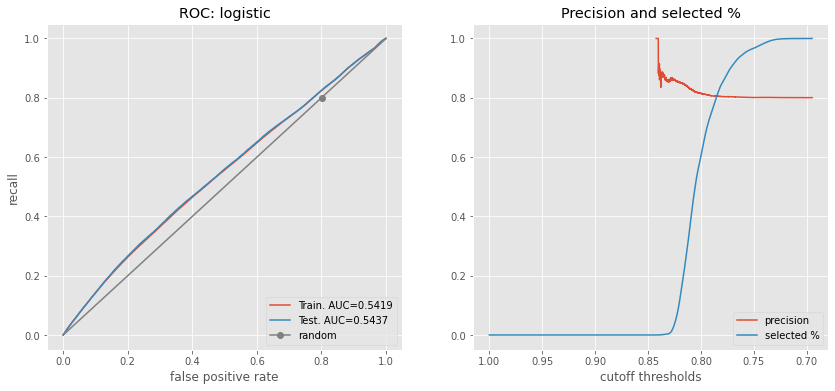

0.54194 0.54370 
{0.05: 0.8578536947642035, 0.1: 0.8525205245365728, 0.2: 0.847537298181075, 1: 0.800408891532228}
installment 	219 sec
model trained in 6.0sec


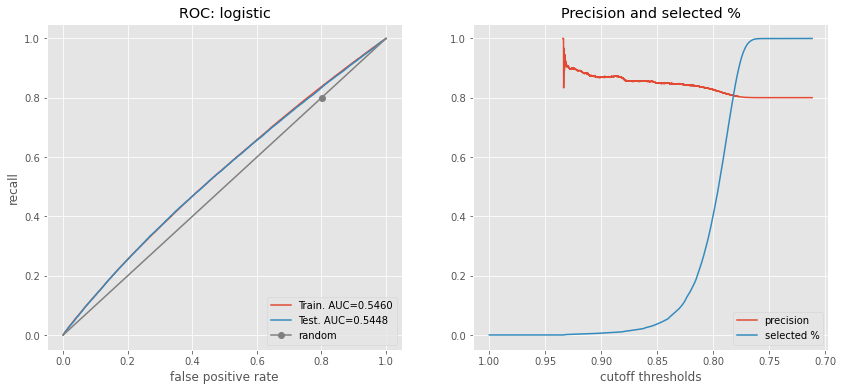

0.54599 0.54477 
{0.05: 0.8488700564971751, 0.1: 0.8453933920541122, 0.2: 0.8391971006412043, 1: 0.800408891532228}
annual_inc 	230 sec
model trained in 4.5sec


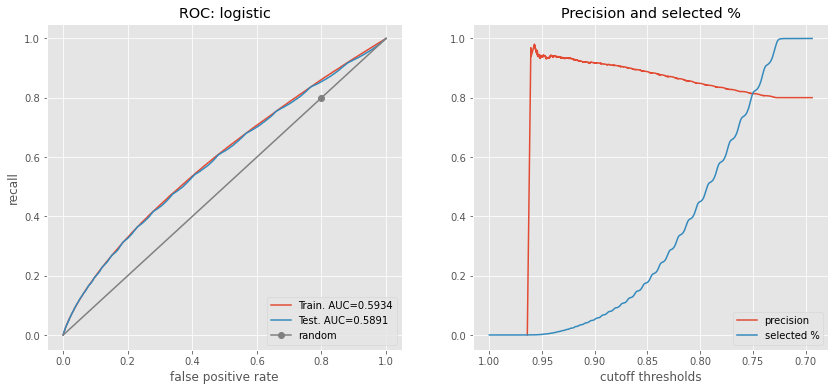

0.59344 0.58911 
{0.05: 0.9186460807600949, 0.1: 0.905630923620145, 0.2: 0.8838778013156428, 1: 0.800408891532228}
fico_range_low 	239 sec
model trained in 6.3sec


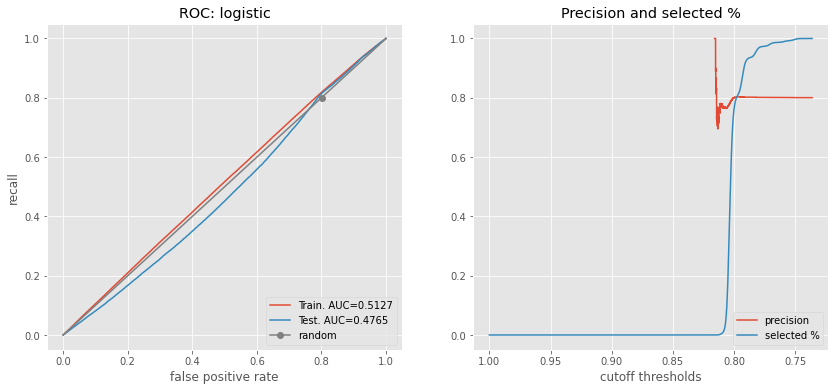

0.51275 0.47647 
{0.05: 0.7648108228647885, 0.1: 0.7648938937822872, 0.2: 0.7718326611779136, 1: 0.800408891532228}
delinq_2yrs 	250 sec
model trained in 22.8sec


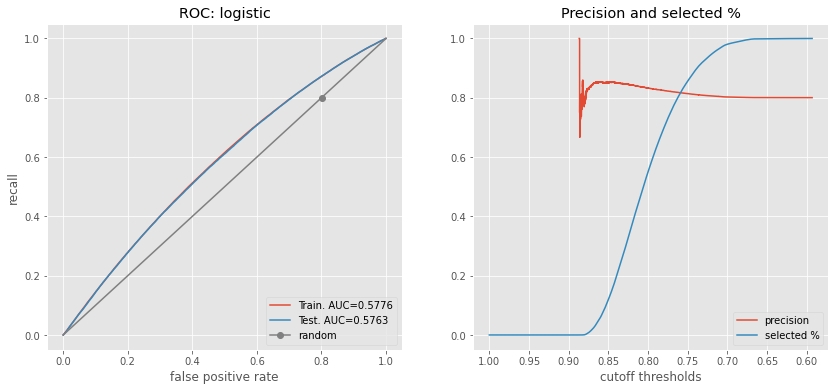

0.57764 0.57634 
{0.05: 0.852077603508511, 0.1: 0.8506336641022781, 0.2: 0.8501626242914226, 1: 0.800408891532228}
dti 	278 sec
model trained in 4.5sec


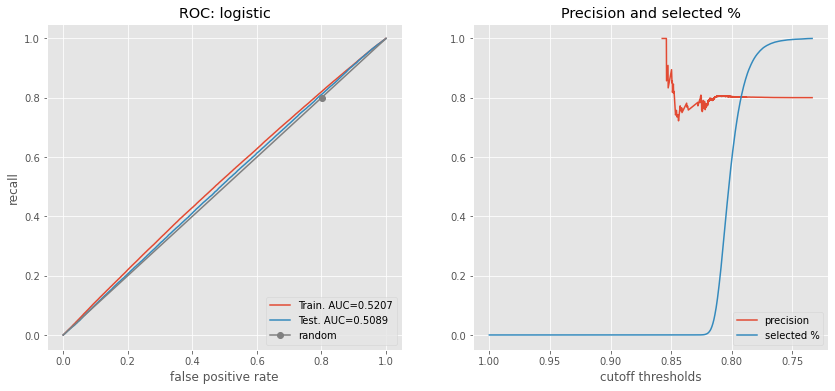

0.52075 0.50890 
{0.05: 0.7953785570993388, 0.1: 0.8042072400208132, 0.2: 0.805226182953574, 1: 0.800408891532228}
open_acc 	288 sec
model trained in 5.9sec


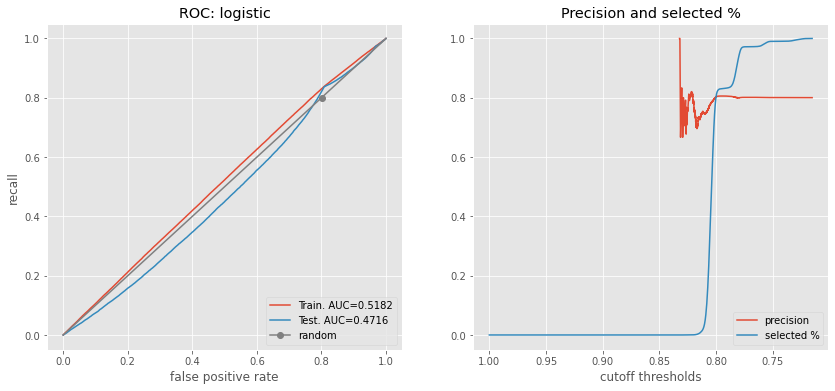

0.51823 0.47159 
{0.05: 0.7465249386753884, 0.1: 0.7525359491695462, 0.2: 0.7624330954504905, 1: 0.800408891532228}
pub_rec 	298 sec
model trained in 6.7sec


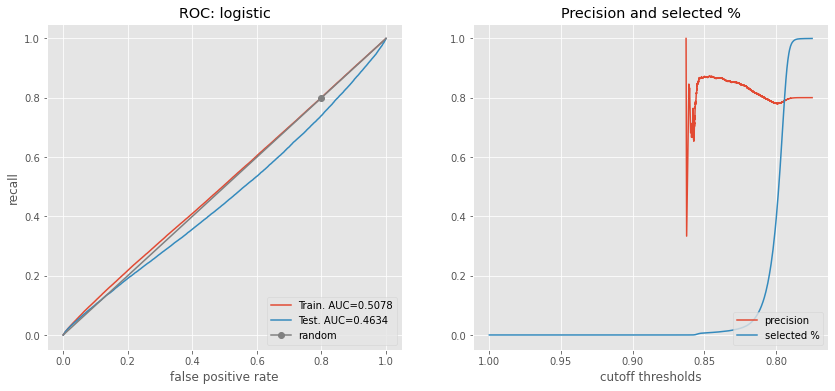

0.50777 0.46340 
{0.05: 0.8206481343838263, 0.1: 0.8043712597108129, 0.2: 0.7918819462513473, 1: 0.800408891532228}
revol_bal 	310 sec
model trained in 6.2sec


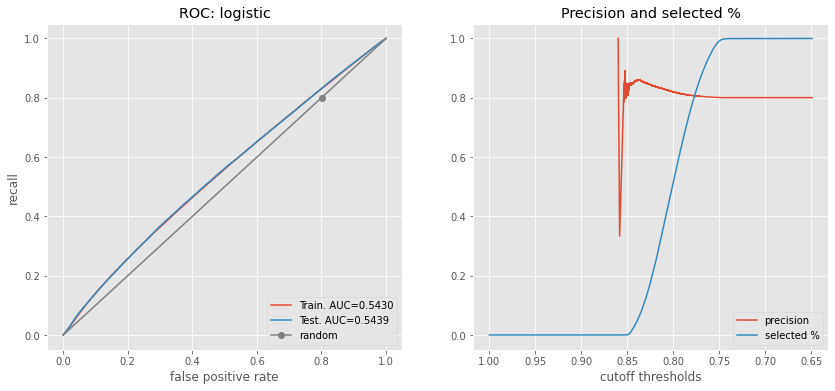

0.54303 0.54393 
{0.05: 0.8580880166517989, 0.1: 0.8529532022451027, 0.2: 0.8411202795123401, 1: 0.800408891532228}
revol_util 	321 sec
model trained in 35.6sec


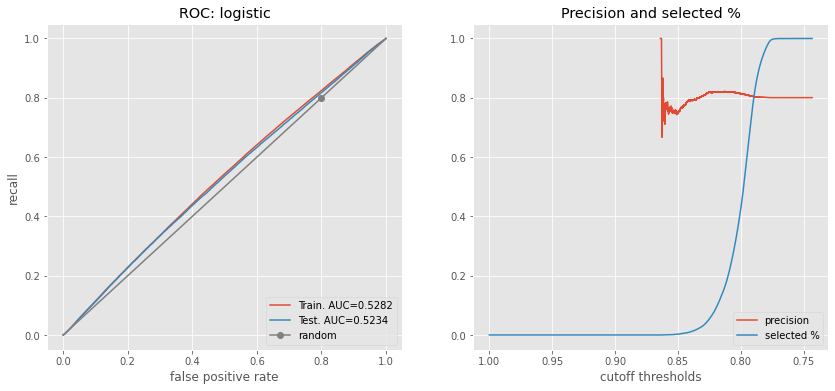

0.52818 0.52340 
{0.05: 0.8173376912791561, 0.1: 0.8192462087421944, 0.2: 0.8202055112696731, 1: 0.800408891532228}
_credit_hist 	361 sec
model trained in 5.2sec


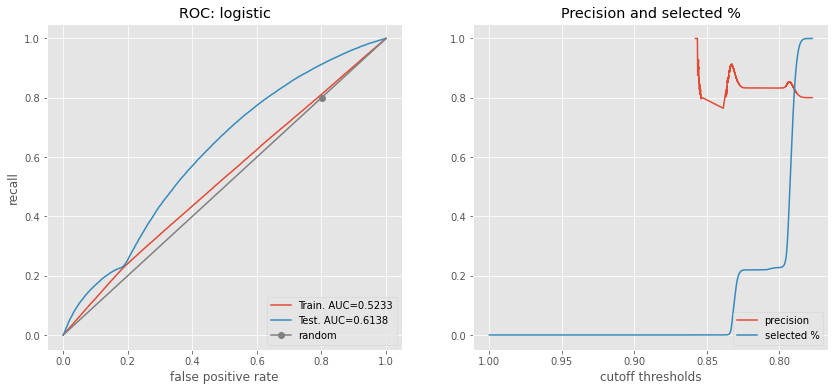

0.52332 0.61383 
{0.05: 0.9087192447781164, 0.1: 0.8942497119280378, 0.2: 0.8500353120469836, 1: 0.800408891532228}
purpose_credit_card 	371 sec
model trained in 6.3sec


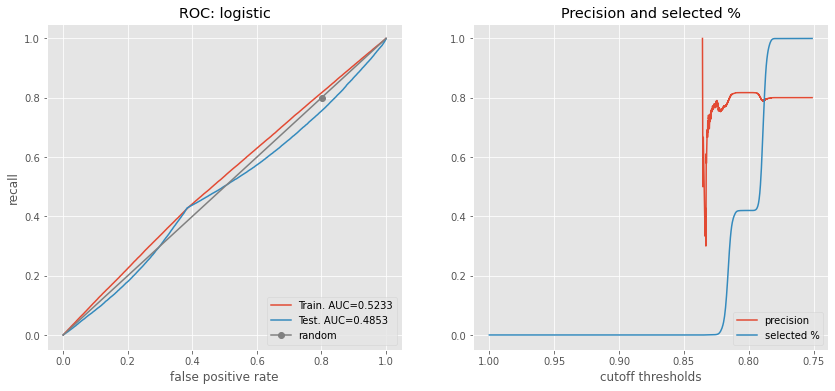

0.52330 0.48527 
{0.05: 0.7709571938168847, 0.1: 0.7716950979299066, 0.2: 0.7856704767214944, 1: 0.800408891532228}
purpose_debt_consolidation 	382 sec
model trained in 11.5sec


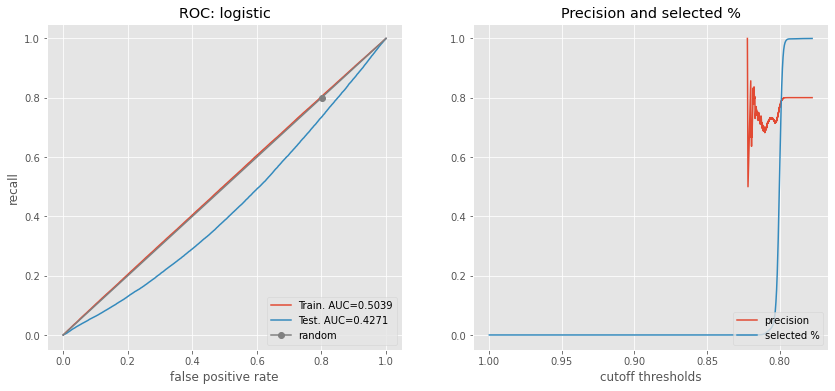

0.50387 0.42714 
{0.05: 0.7222717811477846, 0.1: 0.716733571216176, 0.2: 0.7293896818316977, 1: 0.800408891532228}
purpose_educational 	398 sec
model trained in 5.6sec


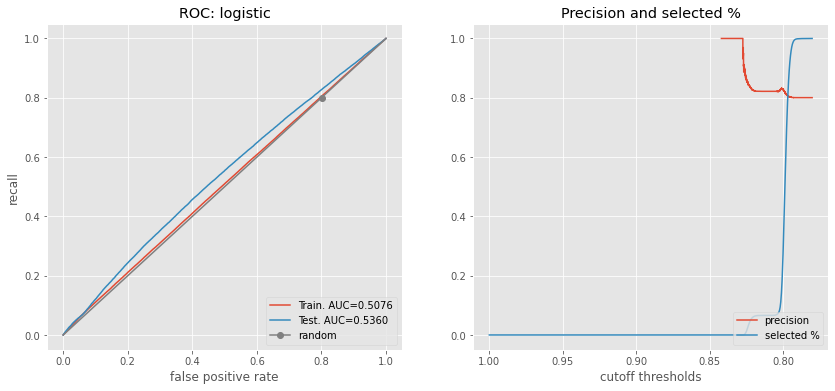

0.50756 0.53604 
{0.05: 0.8346825102116598, 0.1: 0.827436259570356, 0.2: 0.8303261172535539, 1: 0.800408891532228}
purpose_home_improvement 	409 sec
model trained in 5.7sec


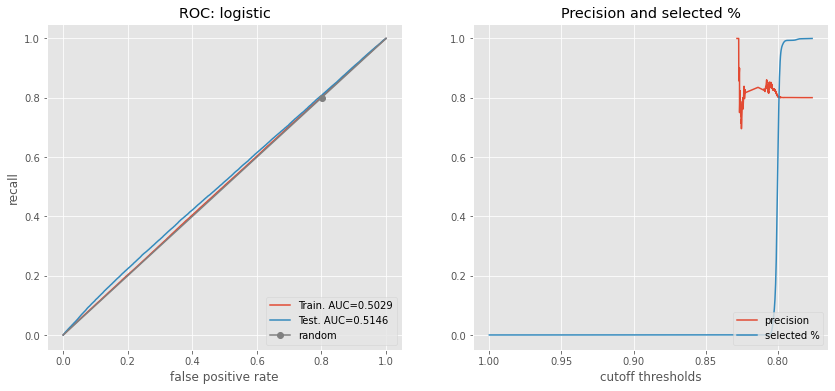

0.50291 0.51459 
{0.05: 0.8275349390425215, 0.1: 0.8273287772990641, 0.2: 0.8192209047318142, 1: 0.800408891532228}
purpose_house 	420 sec
model trained in 4.9sec


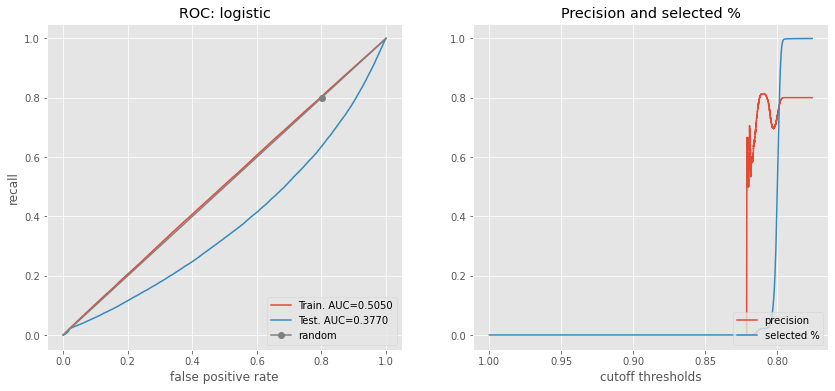

0.50504 0.37705 
{0.05: 0.7163247100802853, 0.1: 0.6969528056484579, 0.2: 0.7039604512424034, 1: 0.800408891532228}
purpose_major_purchase 	429 sec
model trained in 7.4sec


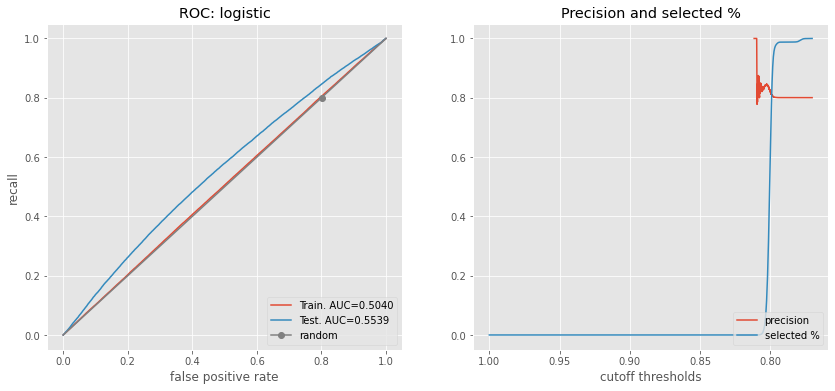

0.50401 0.55392 
{0.05: 0.8400951107148164, 0.1: 0.8450787986916443, 0.2: 0.8422881781180886, 1: 0.800408891532228}
purpose_medical 	442 sec
model trained in 4.2sec


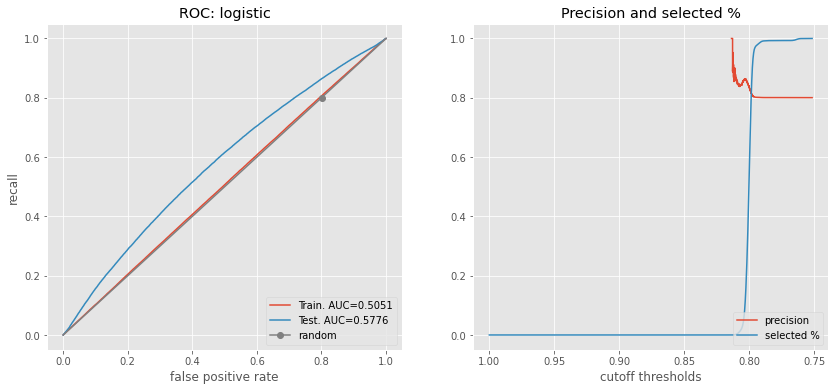

0.50507 0.57764 
{0.05: 0.8586083853702051, 0.1: 0.8629251068574614, 0.2: 0.8580057615463247, 1: 0.800408891532228}
purpose_moving 	451 sec
model trained in 6.3sec


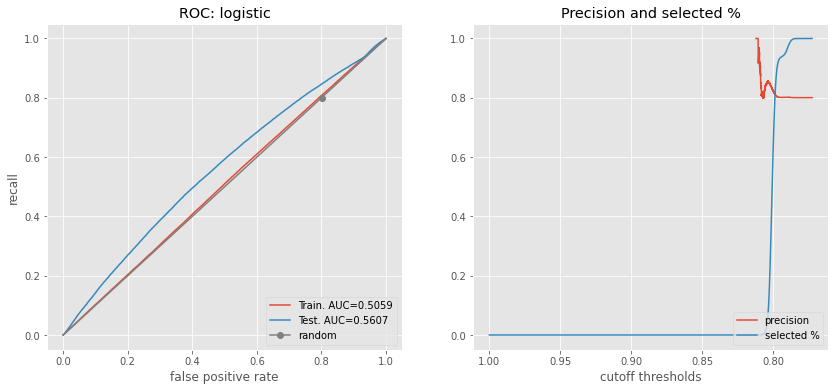

0.50588 0.56071 
{0.05: 0.8543819222478256, 0.1: 0.8521354495781139, 0.2: 0.8473004367623826, 1: 0.800408891532228}
purpose_other 	462 sec
model trained in 28.2sec


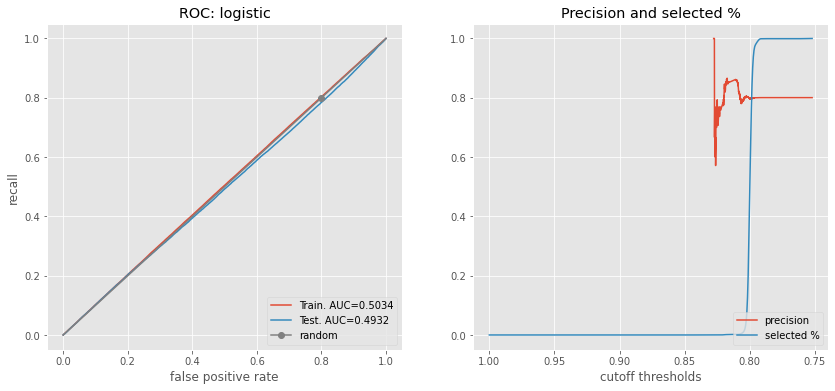

0.50344 0.49320 
{0.05: 0.8028974739970283, 0.1: 0.8031074601345574, 0.2: 0.8025462317628472, 1: 0.800408891532228}
purpose_renewable_energy 	495 sec
model trained in 10.1sec


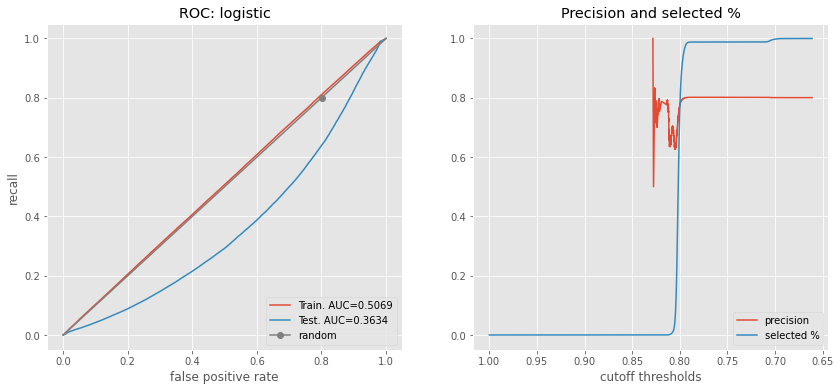

0.50687 0.36341 
{0.05: 0.6272950271314948, 0.1: 0.636448111804936, 0.2: 0.6696589536288448, 1: 0.800408891532228}
purpose_small_business 	510 sec
model trained in 12.6sec


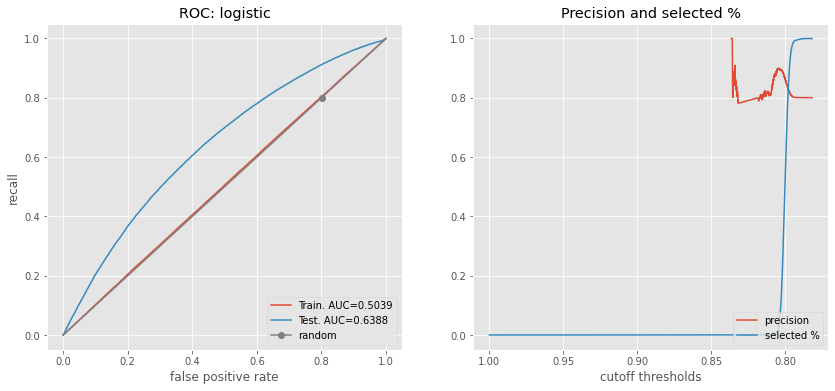

0.50390 0.63880 
{0.05: 0.8968666468666469, 0.1: 0.8934478016872932, 0.2: 0.8897086151787704, 1: 0.800408891532228}
purpose_vacation 	527 sec
model trained in 4.8sec


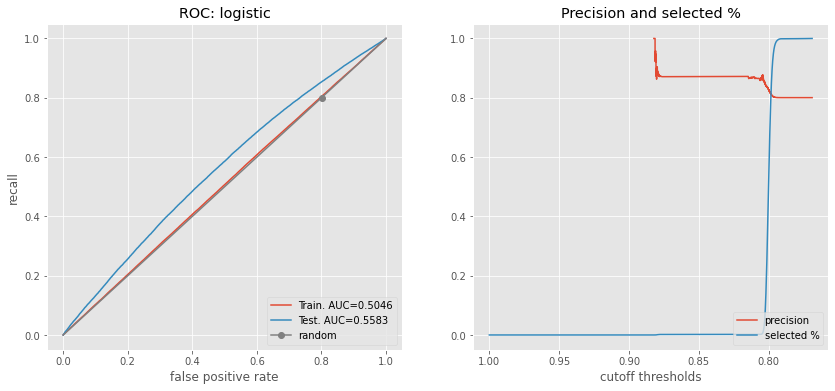

0.50459 0.55827 
{0.05: 0.8494463847811548, 0.1: 0.8446269932721256, 0.2: 0.8398661834402006, 1: 0.800408891532228}
purpose_wedding 	537 sec
model trained in 6.0sec


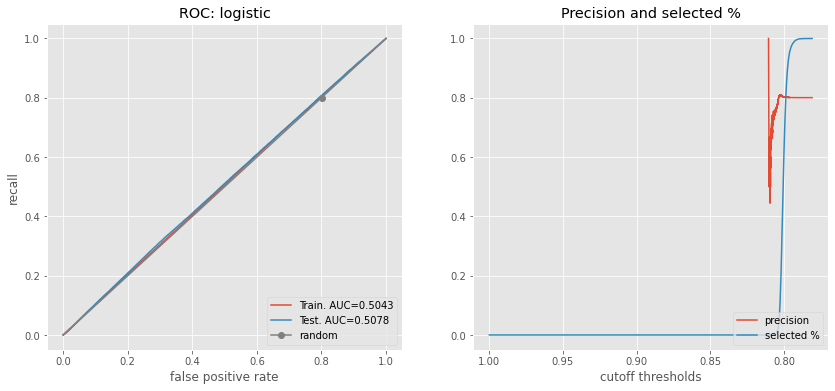

0.50429 0.50777 
{0.05: 0.804725813642443, 0.1: 0.807795199524411, 0.2: 0.8073113163714758, 1: 0.800408891532228}
home_ownership_OTHER 	547 sec
model trained in 4.2sec


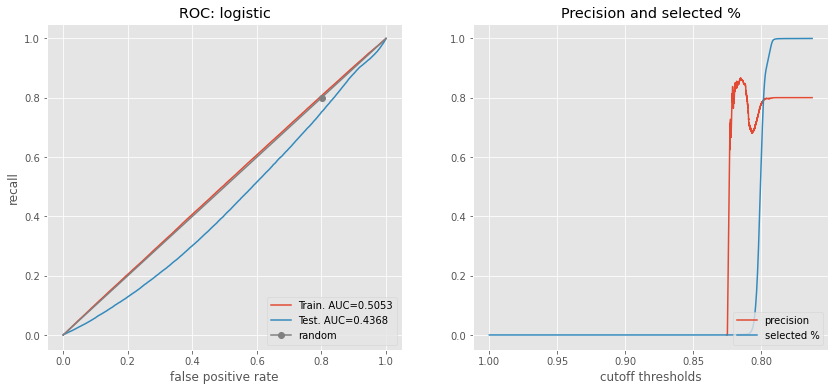

0.50530 0.43679 
{0.05: 0.6922104950200683, 0.1: 0.7109459208325589, 0.2: 0.7321329022187535, 1: 0.800408891532228}
home_ownership_OWN 	556 sec
model trained in 14.8sec


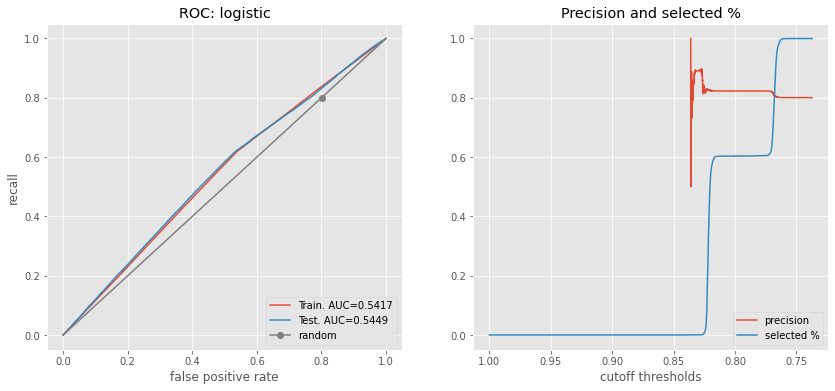

0.54168 0.54492 
{0.05: 0.8263842437755481, 0.1: 0.8292891382705956, 0.2: 0.8281255805313021, 1: 0.800408891532228}
home_ownership_RENT 	576 sec


In [127]:
auc=[]
prec_20=[]
tic = time.time()

for col in X_train.columns:

    X_train_shuffled = X_train.copy()

    for shuffle_col in X_train.columns:
        vals = X_train_shuffled[shuffle_col].values
        if shuffle_col!=col: np.random.shuffle(vals)
        X_train_shuffled[shuffle_col] = vals

    Y_test, Y_test_hat, AUC_train, AUC_test, precision =\
        predict_probs(X_train_shuffled, X_test, Y_train, Y_test, 
                    'logistic',  #'neural network all', 
                    show_plot=True, 
                    verbose=0)
    auc.append(AUC_test)
    prec_20.append(precision[0.2])
    print(f'{col} \t{time.time()-tic:.0f} sec')
    print(60*'=')
    

In [126]:
fi_report = pd.DataFrame({
'feature':X_train.columns[:20],
'AUC_test':auc,
'P_20%':prec_20,
})
fi_report.sort_values(by='AUC_test', ascending=False)

,feature,AUC_test,P_20%
2,sub_grade,0.691525,0.934760
9,int_rate,0.686747,0.934973
1,grade,0.684443,0.932518
3,term,0.653057,0.895681
16,pub_rec,0.610021,0.891998
6,verification_status,0.591958,0.874380
12,fico_range_low,0.589937,0.884918
14,dti,0.573931,0.848676
8,loan_amnt,0.554802,0.842963
17,revol_bal,0.545162,0.830948


In [77]:
timestamp = int(time.time())
fi_report.to_csv(path+f'reports/importance_{timestamp}.csv')

## In-subgrade classification

In [78]:
# a general report dataframe structure:
df_template = pd.DataFrame(columns=['model',
                                  'run',
                                  'sec',
                                  'n_loans',
                                  'AUC_test',
                                  'prec_5',
                                  'prec_10',
                                  'prec_20',
                                  'support',
                                  'lift_5',
                                  'lift_10',
                                  'lift_20',

                                  ])
df_template

,model,run,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20


In [79]:
# CYCLE:
predictions = pd.DataFrame(columns=['_good','p'])
model_name = 'neural_256'
df_report = df_template.copy()

# for term in (0,1):
for sub_grade in range(1,26):

    tic = time.time()

    # X_train_s = X_train[X_train.term==term]
    # X_test_s = X_test[X_test.term==term]
    # Y_train_s = Y_train[X_train.term==term]
    # Y_test_s = Y_test[X_test.term==term]

    X_train_s = X_train[X_train.sub_grade==sub_grade]
    X_test_s = X_test[X_test.sub_grade==sub_grade]
    Y_train_s = Y_train[X_train.sub_grade==sub_grade]
    Y_test_s = Y_test[X_test.sub_grade==sub_grade]

    Y_test_s, Y_test_hat_s, AUC_train, AUC_test, precision =\
        predict_probs(X_train_s, X_test_s, Y_train_s, Y_test_s,
                    model_name, 
                    show_plot=False, 
                    verbose=0)

    Y_test_hat_s = pd.Series(np.squeeze(Y_test_hat_s), name='p', index=Y_test_s.index)
    grade_predictions = pd.concat([Y_test_s, Y_test_hat_s], axis=1)
    predictions = pd.concat([predictions, grade_predictions], axis=0)

    df_report.loc[df_report.shape[0]] = ([model_name] +
                                        # ['3 years' if term==0 else '5 years']+
                                         [sub_grades_dict_reverse[sub_grade]] +
                                         [f'{time.time()-tic:.1f}'] + 
                                         [f'{len(Y_test_s):,}'] +
                                         [np.round(AUC_test, 4)] +
                                         [np.round(x,4) for x in precision.values()] + 
                            [np.round(x/precision[1],4) for x in list(precision.values())[:-1]] 
                                        )
    print(f'{sub_grades_dict_reverse[sub_grade]} \t{time.time()-tic:.1f} sec')


model trained in 7.6sec
0.68332 0.60934 
{0.05: 0.9794520547945207, 0.1: 0.9848484848484849, 0.2: 0.9868571428571429, 1: 0.9725885996100471}
A1 	8.9 sec
model trained in 4.8sec
0.64770 0.60684 
{0.05: 0.9733333333333335, 0.1: 0.9732977303070761, 0.2: 0.9749835418038182, 1: 0.953198972000541}
A2 	5.8 sec
model trained in 6.8sec
0.62917 0.59739 
{0.05: 0.9812734082397004, 0.1: 0.9765929778933681, 0.2: 0.966025641025641, 1: 0.9458996972489141}
A3 	7.7 sec
model trained in 9.7sec
0.63376 0.61623 
{0.05: 0.9672131147540984, 0.1: 0.9691119691119692, 0.2: 0.9620192307692308, 1: 0.9320247534326049}
A4 	11.0 sec
model trained in 9.0sec
0.61113 0.58805 
{0.05: 0.9565217391304346, 0.1: 0.949534161490683, 0.2: 0.9466095089633669, 1: 0.9183545788691639}
A5 	10.5 sec
model trained in 11.5sec
0.61727 0.59301 
{0.05: 0.9426229508196721, 0.1: 0.9378969654199013, 0.2: 0.9299048960901726, 1: 0.8929886685552408}
B1 	13.2 sec
model trained in 5.8sec
0.59707 0.58598 
{0.05: 0.9549071618037135, 0.1: 0.936198

In [80]:
Y_test_hat_s.head()

id
101053261    0.514576
53594216     0.546998
110845564    0.530881
68921558     0.646984
98407254     0.716121
Name: p, dtype: float32

In [81]:
timestamp = int(time.time())
filename = f'per_grade_predictions_{test_mode}_{timestamp}.csv'

predictions.index.rename('id', inplace=True)
predictions.to_csv(path+'features/'+filename)
predictions.shape
predictions.head()

,_good,p
id,,
75941255,1,0.980433
79131574,1,0.986486
73876180,1,0.932799
24665718,1,0.983578
26760045,1,0.948879


In [85]:
# save_report(df_report, test_mode)
df_report

,model,run,sec,n_loans,AUC_test,prec_5,prec_10,prec_20,support,lift_5,lift_10,lift_20
0,neural_256,A1,8.9,"8,719",0.6093,0.9795,0.9848,0.9869,0.9726,1.0071,1.0126,1.0147
1,neural_256,A2,5.8,"7,393",0.6068,0.9733,0.9733,0.9750,0.9532,1.0211,1.0211,1.0229
2,neural_256,A3,7.7,"7,597",0.5974,0.9813,0.9766,0.9660,0.9459,1.0374,1.0324,1.0213
3,neural_256,A4,11.0,"10,342",0.6162,0.9672,0.9691,0.9620,0.9320,1.0378,1.0398,1.0322
4,neural_256,A5,10.5,"12,787",0.5881,0.9565,0.9495,0.9466,0.9184,1.0416,1.0340,1.0308
5,neural_256,B1,13.2,"14,120",0.5930,0.9426,0.9379,0.9299,0.8930,1.0556,1.0503,1.0413
6,neural_256,B2,7.5,"14,821",0.5860,0.9549,0.9362,0.9273,0.8866,1.0770,1.0559,1.0458
7,neural_256,B3,14.9,"16,438",0.6035,0.9269,0.9277,0.9254,0.8716,1.0635,1.0643,1.0617
8,neural_256,B4,14.8,"16,639",0.6035,0.9345,0.9232,0.9103,0.8555,1.0923,1.0791,1.0641
9,neural_256,B5,15.7,"16,341",0.5999,0.9158,0.9120,0.8970,0.8356,1.0960,1.0915,1.0735


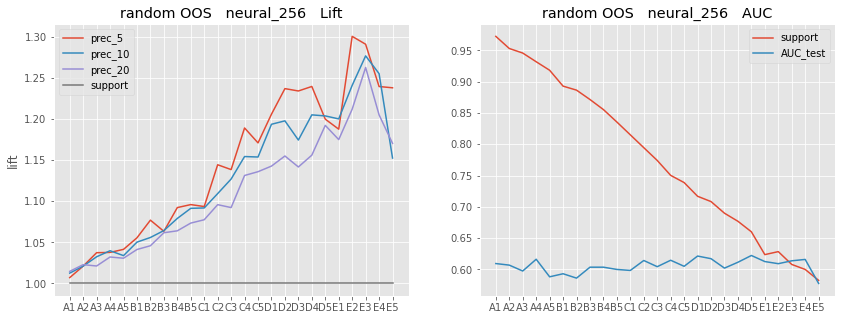

In [86]:
plot_report_metrics(df_report, test_mode)

## In-subgrade feat.imp.

In [123]:
# sub_grade=11

df_report = pd.DataFrame(columns=['sec','AUC_test','fi_1','fi_2','fi_3', 'fi_-3','fi_-2','fi_-1',]) 

for sub_grade in range(1,26):

    tic = time.time()

    X_train_s = X_train[(X_train.sub_grade==sub_grade) & (X_train.term==0)]
    X_test_s = X_test[(X_test.sub_grade==sub_grade) & (X_test.term==0)]
    Y_train_s = Y_train[(X_train.sub_grade==sub_grade) & (X_train.term==0)]
    Y_test_s = Y_test[(X_test.sub_grade==sub_grade) & (X_test.term==0)]

    X_train_s.drop(['grade', 'sub_grade'], axis=1, inplace=True)
    X_test_s.drop(['grade', 'sub_grade'], axis=1, inplace=True)

    model = LogisticRegression(penalty='l1', 
                                C=100, 
                                verbose=1,
                                solver='liblinear') # best HP from BD18
    model.fit(X_train_s, Y_train_s)

    Y_test_hat_s = model.predict_proba(X_test_s)[:,1]
    AUC_test_s = roc_auc_score(Y_test_s, Y_test_hat_s)

    fi = list(zip(X_train_s.columns, model.coef_[0]))
    fi.sort(key=lambda x:x[1], reverse=True) 

    df_report.loc[sub_grades_dict_reverse[sub_grade]] =\
                 [f'{time.time()-tic:.1f}'] + [AUC_test_s] + fi[:3] + fi[-3:]
    
    print(f'{sub_grades_dict_reverse[sub_grade]} \t{time.time()-tic:.1f} sec')



[LibLinear]A1 	2.7 sec
[LibLinear]A2 	3.4 sec
[LibLinear]A3 	0.6 sec
[LibLinear]A4 	0.7 sec
[LibLinear]A5 	0.9 sec
[LibLinear]B1 	1.2 sec
[LibLinear]B2 	3.6 sec
[LibLinear]B3 	4.2 sec
[LibLinear]B4 	0.6 sec
[LibLinear]B5 	4.1 sec
[LibLinear]C1 	5.7 sec
[LibLinear]C2 	2.0 sec
[LibLinear]C3 	1.4 sec
[LibLinear]C4 	4.8 sec
[LibLinear]C5 	1.8 sec
[LibLinear]D1 	2.4 sec
[LibLinear]D2 	2.1 sec
[LibLinear]D3 	0.7 sec
[LibLinear]D4 	2.4 sec
[LibLinear]D5 	6.1 sec
[LibLinear]E1 	2.3 sec
[LibLinear]E2 	0.5 sec
[LibLinear]E3 	0.5 sec
[LibLinear]E4 	0.3 sec
[LibLinear]E5 	0.2 sec


In [124]:
df_report.T

,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5
sec,2.7,3.4,0.6,0.7,0.9,1.2,3.6,4.2,0.6,4.1,5.7,2.0,1.4,4.8,1.8,2.4,2.1,0.7,2.4,6.1,2.3,0.5,0.5,0.3,0.2
AUC_test,0.608704,0.611743,0.601032,0.611521,0.579472,0.571731,0.57152,0.587455,0.580594,0.587321,0.581515,0.582931,0.576559,0.579213,0.584947,0.578034,0.586173,0.587127,0.604301,0.606064,0.594954,0.568942,0.608216,0.61521,0.571438
fi_1,"(home_ownership_OTHER, 3.478512269680789)","(home_ownership_OTHER, 2.9354562040581267)","(purpose_educational, 3.6387601861369694)","(home_ownership_OTHER, 3.789262509526361)","(purpose_renewable_energy, 0.17928529652227565)","(purpose_educational, 4.240438147390379)","(_has_desc, 0.1862797655778765)","(purpose_wedding, 0.3771623713781651)","(purpose_renewable_energy, 0.46751463911264396)","(purpose_house, 0.2350284184593827)","(_has_desc, 0.13578642558018722)","(purpose_educational, 0.23807704743661304)","(purpose_wedding, 1.0843257715642594)","(_has_desc, 0.26779312892466284)","(home_ownership_OTHER, 5.475045426053788)","(purpose_wedding, 0.39998179767889663)","(purpose_wedding, 0.7968059991645793)","(purpose_wedding, 0.9173495686474057)","(home_ownership_OTHER, 0.826384252987868)","(purpose_wedding, 0.5060800077017095)","(purpose_wedding, 0.7678867319758733)","(purpose_wedding, 0.30726437566856946)","(purpose_educational, 3.180053740775841)","(purpose_wedding, 0.8607698923023522)","(_has_desc, 0.31766036914869344)"
fi_2,"(purpose_credit_card, 0.47138985667587435)","(purpose_educational, 2.60023817924243)","(home_ownership_OTHER, 3.626849681568844)","(int_rate, 0.11801307228838274)","(int_rate, 0.08105907172521037)","(initial_list_status, 0.059299717390367136)","(purpose_credit_card, 0.07843600785742677)","(initial_list_status, 0.12160217051021109)","(purpose_wedding, 0.2075391349132742)","(purpose_educational, 0.15673597894681845)","(int_rate, 0.09221120112936129)","(_has_desc, 0.20011220893210296)","(purpose_renewable_energy, 0.5708383991393103)","(purpose_educational, 0.10174354178634132)","(_has_desc, 0.24233141063308405)","(home_ownership_OTHER, 0.3053071506554412)","(_has_desc, 0.3333361525965349)","(_has_desc, 0.3241982889686508)","(purpose_wedding, 0.301203996453062)","(purpose_vacation, 0.29076979861003144)","(_has_desc, 0.3400513708060666)","(_has_desc, 0.3007970115872782)","(purpose_renewable_energy, 1.4510832168451149)","(purpose_medical, 0.7762821544183786)","(_credit_hist, 0.01608386329785844)"
fi_3,"(purpose_major_purchase, 0.4357487481793906)","(purpose_wedding, 1.1253636135933722)","(purpose_renewable_energy, 3.3489011196865546)","(initial_list_status, 0.014324623575615843)","(_has_desc, 0.050664031050320184)","(int_rate, 0.04543766336988817)","(purpose_debt_consolidation, 0.050132624606134...","(int_rate, 0.05140499471298536)","(int_rate, 0.13570914719365196)","(int_rate, 0.09260978203901823)","(initial_list_status, 0.04374297907337957)","(home_ownership_OTHER, 0.17126089573322056)","(_has_desc, 0.10948923853884143)","(initial_list_status, 0.07834555357008026)","(initial_list_status, 0.0912073474531182)","(_has_desc, 0.26223137392730517)","(purpose_house, 0.20744307458033834)","(purpose_vacation, 0.3065147216352225)","(_has_desc, 0.21727969754385887)","(_has_desc, 0.2731957219966897)","(purpose_moving, 0.241833574885331)","(application_type, 0.196137669645711)","(purpose_vacation, 0.4123655666436295)","(purpose_other, 0.6756247514996613)","(pub_rec, 0.013690531707660804)"
fi_-3,"(home_ownership_RENT, -0.47581717434866816)","(purpose_vacation, -0.5816895591034285)","(application_type, -0.631917340723727)","(application_type, -0.7815175629273574)","(purpose_moving, -0.6174623879213587)","(purpose_vacation, -0.6498589616313075)","(purpose_educational, -0.626294135331097)","(purpose_medical, -0.6467909172174394)","(purpose_small_business, -0.3737072535240186)","(purpose_medical, -0.35795209484680446)","(purpose_house, -0.4489146365280347)","(home_ownership_RENT, -0.385844372103047)","(home_ownership_R